## Notebook to generate collision rate violators for any RMG job while running

In [1]:
import logging
import numpy as np
import os
import sys

In [2]:
import os, sys
rmg_path = os.getenv('RMGpy')
if rmg_path not in sys.path:
    sys.path.append(rmg_path)
sys.path

import rmgpy
from rmgpy.chemkin import load_chemkin_file
from rmgpy.rmgobject import RMGObject, expand_to_dict, recursive_make_object

print(f"RMG-Py Version {rmgpy.__version__}")
print(rmgpy.__file__)

RDKit WARNING: [21:05:01] Enabling RDKit 2019.09.1 jupyter extensions


RMG-Py Version 3.0.0
/scratch/ajulu.c/Code/RMG-Py/rmgpy/__init__.py


In [3]:
chemkin_file = '../chemkin/chem_annotated.inp'
chemkin_folder = os.path.split(chemkin_file)[0]
species_dictionary_file = os.path.join(chemkin_folder, 'species_dictionary.txt')
transport_file = os.path.join(chemkin_folder, 'tran.dat')

In [4]:
species, reactions = rmgpy.chemkin.load_chemkin_file(
                    chemkin_file, species_dictionary_file,transport_path=transport_file,
                    check_duplicates=False, use_chemkin_names=True,read_comments=True)



In [5]:
species_dict = {rmgpy.chemkin.get_species_identifier(s): s for s in species}
species_dict.keys()

dict_keys(['N2', 'Ar', 'Ne', 'n-pch(1)', 'CH(2)', 'C2H(3)', 'CO(4)', 'CO2(5)', 'CH2O(6)', 'C2H4(7)', 'C3H6(8)', 'H2(9)', 'iC4H8(10)', 'OH(11)', 'H(12)', 'O2(13)', 'C9H18(14)', 'C9H18(15)', 'C9H18(16)', 'C9H18(17)', 'C9H18(18)', 'C9H18(19)', 'O_1(20)', 'ROH_1(21)', 'HO2_1(22)', 'H2O2(23)', 'CH3_1(24)', 'RCH4_1(25)', 'C9H16(26)', 'C9H16(27)', 'C9H16(28)', 'C9H16(29)', 'C8H14(30)', 'C9H16(31)', 'C7H12(32)', 'C6H10(33)', 'C9H16(34)', 'C6H11(35)', 'C7H13(36)', 'C9H17(37)', 'C9H17(38)', 'C9H17(39)', 'C9H17(40)', 'C9H17(41)', 'C9H17(42)', 'C9H17(43)', 'C8H15(44)', 'C7H13(45)', 'QOOH_1(46)', 'QOOH_2(47)', 'QOOH_3(48)', 'QOOH_4(49)', 'QOOH_5(50)', 'QOOH_6(51)', 'QOOH_7(52)', 'QOOH_8(53)', 'QOOH_9(54)', 'C7H13(55)', 'C7H13(56)', 'C7H13(57)', 'C3H7(58)', 'C3H7(59)', 'C8H15(60)', 'C8H15(61)', 'C8H15(62)', 'C8H15(63)', 'C8H15(64)', 'C8H15(65)', 'He(66)', 'HOCO(67)', 'HCO(68)', 'CH2(69)', 'CH3OH(70)', 'CH2(S)(71)', 'CH2OH(72)', 'CH3O(73)', 'HCOH(74)', 'CH3OO(75)', 'CH2CO(76)', 'C2H5(77)', 'C2H3(78)'

In [6]:
len(species), len(reactions)

(785, 38677)

In [7]:
def check_collision_limit_violation(self, t_min, t_max, p_min, p_max):
        """
        Warn if a core reaction violates the collision limit rate in either the forward or reverse direction
        at the relevant extreme T/P conditions. Assuming a monotonic behaviour of the kinetics.
        Returns a list with the reaction object and the direction in which the violation was detected.
        """
        conditions = [[t_min, p_min]]
        if t_min != t_max:
            conditions.append([t_max, p_min])
        if self.kinetics.is_pressure_dependent() and p_max != p_min:
            conditions.append([t_min, p_max])
            if t_min != t_max:
                conditions.append([t_max, p_max])
        logging.debug("Checking whether reaction {0} violates the collision rate limit...".format(self))
        violator_list = []
        kf_list = []
        kr_list = []
        collision_limit_f = []
        collision_limit_r = []
        for condition in conditions:
            if len(self.reactants) >= 2:
                try:
                    collision_limit_f.append(self.calculate_coll_limit(temp=condition[0], reverse=False))
                except ValueError:
                    continue
                else:
                    kf_list.append(self.get_rate_coefficient(condition[0], condition[1]))
            if len(self.products) >= 2:
                try:
                    collision_limit_r.append(self.calculate_coll_limit(temp=condition[0], reverse=True))
                except ValueError:
                    continue
                else:
                    kr_list.append(self.generate_reverse_rate_coefficient().get_rate_coefficient(condition[0], condition[1]))
        if len(self.reactants) >= 2:
            for i, k in enumerate(kf_list):
                if k > collision_limit_f[i]:
                    ratio = k / collision_limit_f[i]
                    condition = '{0} K, {1:.1f} bar'.format(conditions[i][0], conditions[i][1] / 1e5)
                    violator_list.append([self, 'forward', ratio, condition])
        if len(self.products) >= 2:
            for i, k in enumerate(kr_list):
                if k > collision_limit_r[i]:
                    ratio = k / collision_limit_r[i]
                    condition = '{0} K, {1:.1f} bar'.format(conditions[i][0], conditions[i][1] / 1e5)
                    violator_list.append([self, 'reverse', ratio, condition])
        return violator_list

In [8]:
import numpy as np
np.linalg.LinAlgError

numpy.linalg.linalg.LinAlgError

In [9]:
violators = []
for r in reactions:
    try:
        v = check_collision_limit_violation(r, 500,1500, 1e5, 40e5)
    except np.linalg.LinAlgError:
        print(f"LinAlgError checking {r}")
    if v:
        print(r)
        violators.extend(v)

H(12) + HO2_1(22) <=> H2O2(23)
CH3_1(24) <=> H2(9) + CH(2)
CH3_1(24) <=> H(12) + CH2(69)
CH2(69) <=> H(12) + CH(2)
CH2(69) <=> H2(9) + C(79)
C2H2(80) <=> H(12) + C2H(3)
C2O(100) <=> C(79) + CO(4)


/scratch/ajulu.c/anaconda3/envs/rmg_py3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


HO2_1(22) + S(103) => O2(13) + CH2OH(72) + CH2OOH(82)
CH2O(6) + S(103) => HCO(68) + CH2OH(72) + CH2OOH(82)
O_1(20) + C2H2(80) <=> OH(11) + C2H(3)
CH3CO(104) + CH3CO(104) <=> CH2CO(76) + CH3CHO(84)
OCHCO(108) + CH3CO(104) <=> CH2CO(76) + OCHCHO(95)
HOCO(67) + CH3CO(104) <=> HOCHO(106) + CH2CO(76)
HCO(68) + CH3CO(104) <=> CH2O(6) + CH2CO(76)
CH3CO(104) + C2H5O(102) <=> C2H4O(89) + CH3CHO(84)
CH3O(73) + CH3CO(104) <=> CH2O(6) + CH3CHO(84)
CH3CO(104) + C2H5(77) <=> C2H4(7) + CH3CHO(84)
CH3CO(104) + C3H7(59) <=> CH3CHO(84) + C3H6(8)
CH3CO(104) + C8H15(64) <=> CH3CHO(84) + C8H14(30)
CH3CO(104) + QOOH_5(50) <=> CH3CHO(84) + C9H16(31)
CH3CO(104) + C7H13(55) <=> CH3CHO(84) + C7H12(32)
OCHCO(108) + C2H5O(102) <=> OCHCHO(95) + C2H4O(89)
HOCO(67) + C2H5O(102) <=> HOCHO(106) + C2H4O(89)
CH3O(73) + OCHCO(108) <=> CH2O(6) + OCHCHO(95)
OCHCO(108) + C2H5(77) <=> OCHCHO(95) + C2H4(7)
OCHCO(108) + C3H7(59) <=> OCHCHO(95) + C3H6(8)
OCHCO(108) + C8H15(64) <=> OCHCHO(95) + C8H14(30)
OCHCO(108) + QOOH_5(50) 

C9H17(300) + S(45578) <=> S(45575) + C9H18(14)
C9H17(309) + S(45578) <=> S(45575) + C9H18(14)
C9H17(309) + S(46389) <=> S(46386) + C9H18(14)
C9H17(300) + S(46389) <=> S(46386) + C9H18(14)
C4H81(132) + C9H17(300) <=> C4H7(345) + C9H18(14)
C4H81(132) + C9H17(309) <=> C4H7(486) + C9H18(14)
C9H17(300) + S(9684) <=> S(9667) + C9H18(14)
S(10185) + C9H17(300) <=> S(10167) + C9H18(14)
S(3271) + C9H17(300) <=> S(2734) + C9H18(14)
S(44703) + C9H17(300) <=> S(44700) + C9H18(14)
C9H17(309) + S(9684) <=> S(9667) + C9H18(14)
S(10185) + C9H17(309) <=> S(10167) + C9H18(14)
S(3271) + C9H17(309) <=> S(2734) + C9H18(14)
S(44703) + C9H17(309) <=> S(44700) + C9H18(14)
O2(13) + C7H13(358) <=> HO2_1(22) + S(8847)
H(12) + lC5H7(141) <=> CH3_1(24) + nC4H5(128)
C3H6(8) + C9H17(300) <=> aC3H5(124) + C9H18(14)
C3H6(8) + C9H17(309) <=> C3H5(123) + C9H18(14)
O2(13) + C9H17(309) <=> HO2_1(22) + S(6496)
S(3415) + C9H17(300) <=> S(9451) + C9H18(14)
C7H12(32) + C9H17(300) <=> S(1090) + C9H18(14)
CH3CO(104) + C6H11(199)

In [10]:
from rmgpy.data.kinetics import TemplateReaction, LibraryReaction
from rmgpy.rmg.pdep import PDepReaction

In [11]:
violators.sort(key = lambda violator: -violator[2])

Text(0.5, 0, 'reaction index (of 38677 total)')

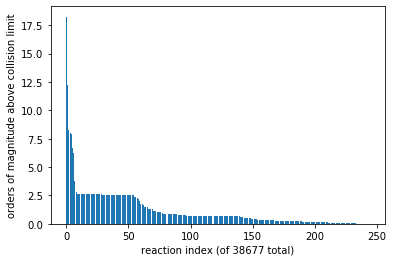

In [12]:
ratios = [np.log10(violator[2]) for violator in violators]
from matplotlib import pyplot as plt
plt.bar(np.arange(len(ratios)), ratios)
plt.ylabel("orders of magnitude above collision limit")
plt.xlabel(f"reaction index (of {len(reactions)} total)")

In [13]:
len(ratios), len(reactions)

(245, 38677)

In [14]:
for violator in violators[:100]:
    rxn_string = str(violator[0])
    direction = {'forward':'=>','reverse':'<='}[violator[1]]
    ratio = violator[2]
    print(f"{rxn_string.replace('<=>',direction) :54s}  {ratio :.1g}  ")

CH2O(6) + S(103) => HCO(68) + CH2OH(72) + CH2OOH(82)    2e+18  
C6H5(135) => H(12) + C2H2(80) + C4H2(117)               2e+12  
CH3_1(24) <= H(12) + CH2(69)                            2e+08  
HO2_1(22) + S(103) => O2(13) + CH2OH(72) + CH2OOH(82)   9e+07  
CH3_1(24) <= H2(9) + CH(2)                              8e+07  
CH3_1(24) <= H(12) + CH2(69)                            5e+06  
CH3_1(24) <= H2(9) + CH(2)                              2e+06  
C2H2(80) <= H(12) + C2H(3)                              6e+03  
S(382) + C9H17(300) <= S(9816) + C9H18(14)              7e+02  
CH2(69) <= H(12) + CH(2)                                5e+02  
S(28969) + C9H17(300) <= S(28962) + C9H18(14)           4e+02  
S(37526) + C9H17(300) <= S(37521) + C9H18(14)           4e+02  
S(44703) + C9H17(300) <= S(44700) + C9H18(14)           4e+02  
S(10510) + C9H17(300) <= S(2729) + C9H18(14)            4e+02  
C9H17(300) + S(46389) <= S(46386) + C9H18(14)           4e+02  
C9H17(300) + S(4131) <= S(4128) + C9H18(

In [15]:
from collections import Counter
counter = Counter( type(v[0].kinetics) for v in violators )
counter

Counter({rmgpy.kinetics.arrhenius.Arrhenius: 231,
         rmgpy.kinetics.falloff.ThirdBody: 12,
         rmgpy.kinetics.falloff.Troe: 1,
         rmgpy.kinetics.chebyshev.Chebyshev: 1})

In [16]:
from collections import Counter
import re

CH2O(6) + S(103) => HCO(68) + CH2OH(72) + CH2OOH(82)
Arrhenius(A=(41000,'cm^3/(mol*s)'), n=2.5, Ea=(10.206,'kcal/mol'), T0=(1,'K'))
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1.8e+18
Violation condition: 500 K, 1.0 bar




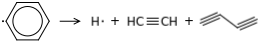

C6H5(135) => H(12) + C2H2(80) + C4H2(117)
Arrhenius(A=(4.3e+12,'s^-1'), n=0.62, Ea=(77.294,'kcal/mol'), T0=(1,'K'))
Kinetic library: CurranPentane
Direction: reverse
Violation factor: 1.7e+12
Violation condition: 500 K, 1.0 bar




CH3_1(24) <=> H(12) + CH2(69)
ThirdBody(arrheniusLow=Arrhenius(A=(2.2e+15,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1.9e+08
Violation condition: 500 K, 40.0 bar




HO2_1(22) + S(103) => O2(13) + CH2OH(72) + CH2OOH(82)
Arrhenius(A=(2.5e+11,'cm^3/(mol*s)'), n=0, Ea=(-1.49,'kcal/mol'), T0=(1,'K'))
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 9.3e+07
Violation condition: 500 K, 1.0 bar




CH3_1(24) <=> H2(9) + CH(2)
ThirdBody(arrheniusLow=Arrhenius(A=(3.1e+15,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 7.6e+07
Violation condition: 500 K, 40.0 bar




CH3_1(24) <=> H(12) + CH2(69)
ThirdBody(arrheniusLow=Arrhenius(A=(2.2e+15,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 4.9e+06
Violation condition: 500 K, 1.0 bar




CH3_1(24) <=> H2(9) + CH(2)
ThirdBody(arrheniusLow=Arrhenius(A=(3.1e+15,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1.9e+06
Violation condition: 500 K, 1.0 bar




C2H2(80) <=> H(12) + C2H(3)
ThirdBody(arrheniusLow=Arrhenius(A=(9.1e+30,'cm^3/(mol*s)'), n=-3.7, Ea=(127.138,'kcal/mol'), T0=(1,'K')), efficiencies={Molecule(smiles="[C-]#[O+]"): 2.0, Molecule(smiles="[H][H]"): 2.0, Molecule(smiles="O=C=O"): 3.0, Molecule(smiles="O"): 5.0})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 5.6e+03
Violation condition: 500 K, 40.0 bar




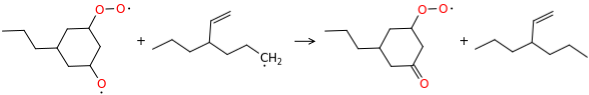

S(382) + C9H17(300) <=> S(9816) + C9H18(14)
Arrhenius(A=(8.43e+11,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Estimated using template [C_rad/H2/Cs;C/H/NdNd_Rrad] for rate rule [C_rad/H2/Cs;C/H/NdNd_Orad]
Euclidian distance = 1.0
family: Disproportionation
Direction: reverse
Violation factor: 6.8e+02
Violation condition: 1500 K, 1.0 bar




CH2(69) <=> H(12) + CH(2)
ThirdBody(arrheniusLow=Arrhenius(A=(5.6e+15,'cm^3/(mol*s)'), n=0, Ea=(89,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 4.5e+02
Violation condition: 500 K, 40.0 bar




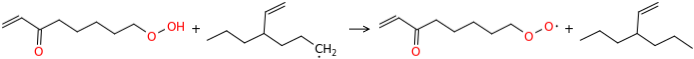

S(28969) + C9H17(300) <=> S(28962) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 4.2e+02
Violation condition: 1500 K, 1.0 bar




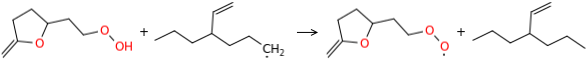

S(37526) + C9H17(300) <=> S(37521) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 4.2e+02
Violation condition: 1500 K, 1.0 bar




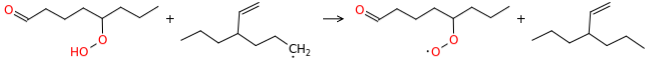

S(44703) + C9H17(300) <=> S(44700) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 4.1e+02
Violation condition: 1500 K, 1.0 bar




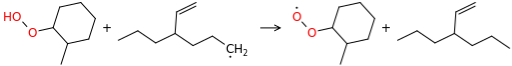

S(10510) + C9H17(300) <=> S(2729) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 4.1e+02
Violation condition: 1500 K, 1.0 bar




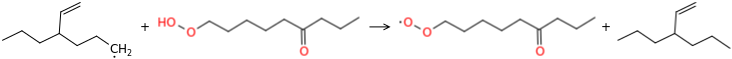

C9H17(300) + S(46389) <=> S(46386) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 4e+02
Violation condition: 1500 K, 1.0 bar




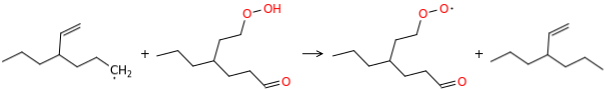

C9H17(300) + S(4131) <=> S(4128) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 4e+02
Violation condition: 1500 K, 1.0 bar




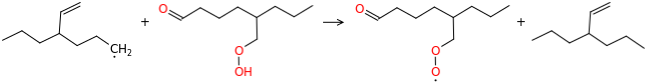

C9H17(300) + S(26883) <=> S(26880) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 4e+02
Violation condition: 1500 K, 1.0 bar




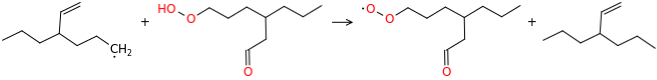

C9H17(300) + S(28231) <=> S(28198) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 4e+02
Violation condition: 1500 K, 1.0 bar




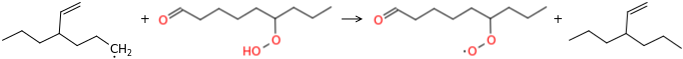

C9H17(300) + S(45578) <=> S(45575) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 4e+02
Violation condition: 1500 K, 1.0 bar




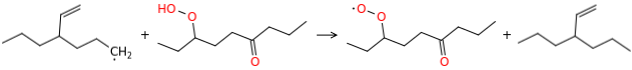

C9H17(300) + S(19484) <=> S(19473) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 4e+02
Violation condition: 1500 K, 1.0 bar




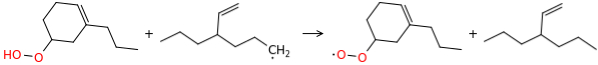

S(3416) + C9H17(300) <=> S(8199) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.9e+02
Violation condition: 1500 K, 1.0 bar




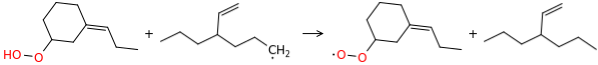

S(3415) + C9H17(300) <=> S(9447) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.9e+02
Violation condition: 1500 K, 1.0 bar




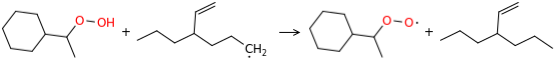

S(3271) + C9H17(300) <=> S(2734) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.9e+02
Violation condition: 1500 K, 1.0 bar




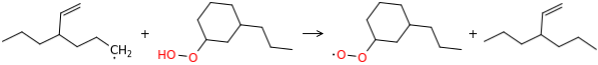

C9H17(300) + S(3113) <=> S(2727) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.9e+02
Violation condition: 1500 K, 1.0 bar




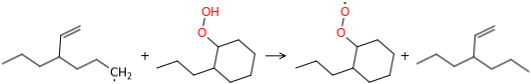

C9H17(300) + S(3210) <=> S(2722) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.9e+02
Violation condition: 1500 K, 1.0 bar




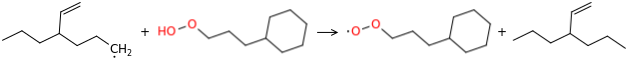

C9H17(300) + S(7578) <=> S(2726) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.8e+02
Violation condition: 1500 K, 1.0 bar




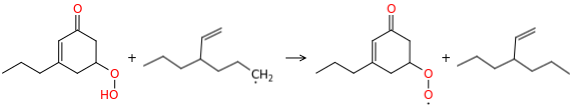

S(10012) + C9H17(300) <=> S(10901) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.8e+02
Violation condition: 1500 K, 1.0 bar




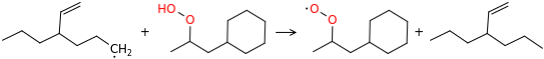

C9H17(300) + S(3151) <=> S(2725) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.8e+02
Violation condition: 1500 K, 1.0 bar




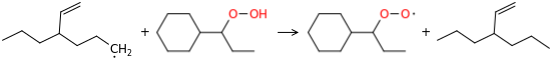

C9H17(300) + S(3265) <=> S(2724) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.8e+02
Violation condition: 1500 K, 1.0 bar




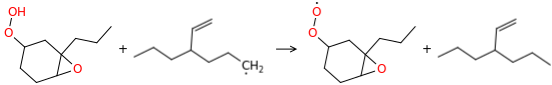

S(8117) + C9H17(300) <=> S(11576) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.8e+02
Violation condition: 1500 K, 1.0 bar




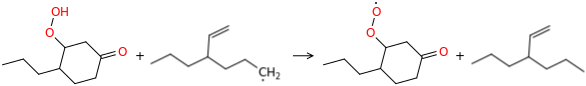

S(8431) + C9H17(300) <=> S(8508) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.8e+02
Violation condition: 1500 K, 1.0 bar




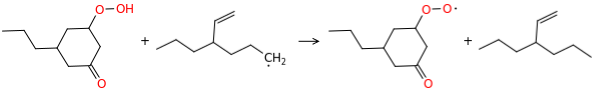

S(9815) + C9H17(300) <=> S(9816) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.8e+02
Violation condition: 1500 K, 1.0 bar




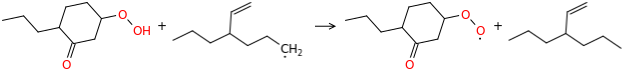

S(9130) + C9H17(300) <=> S(9208) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.8e+02
Violation condition: 1500 K, 1.0 bar




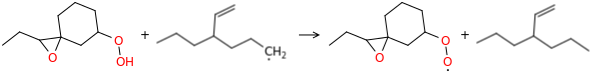

S(7907) + C9H17(300) <=> S(7924) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.8e+02
Violation condition: 1500 K, 1.0 bar




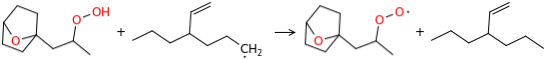

S(8301) + C9H17(300) <=> S(8310) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.8e+02
Violation condition: 1500 K, 1.0 bar




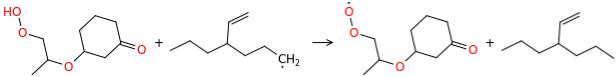

S(18139) + C9H17(300) <=> S(18136) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.7e+02
Violation condition: 1500 K, 1.0 bar




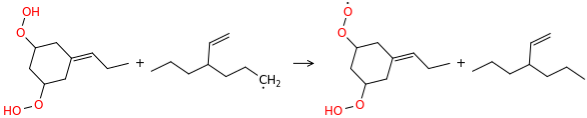

S(41325) + C9H17(300) <=> S(41287) + C9H18(14)
Arrhenius(A=(5.02e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.6e+02
Violation condition: 1500 K, 1.0 bar




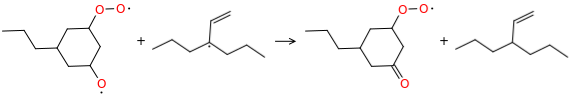

S(382) + C9H17(309) <=> S(9816) + C9H18(14)
Arrhenius(A=(1.08e+14,'cm^3/(mol*s)'), n=-0.75, Ea=(0,'kcal/mol'), T0=(1,'K'))
Estimated using template [C_ter_rad;C/H/NdNd_Rrad] for rate rule [C_rad/Cs2;C/H/NdNd_Orad]
Euclidian distance = 2.23606797749979
family: Disproportionation
Direction: reverse
Violation factor: 3.6e+02
Violation condition: 1500 K, 1.0 bar




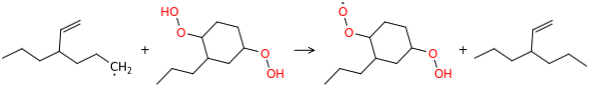

C9H17(300) + S(7630) <=> S(7628) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.6e+02
Violation condition: 1500 K, 1.0 bar




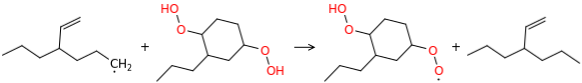

C9H17(300) + S(7630) <=> S(7602) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.6e+02
Violation condition: 1500 K, 1.0 bar




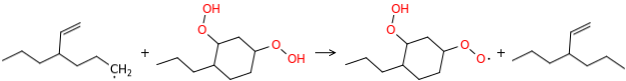

C9H17(300) + S(7361) <=> S(7360) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.6e+02
Violation condition: 1500 K, 1.0 bar




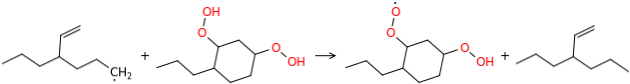

C9H17(300) + S(7361) <=> S(7297) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.6e+02
Violation condition: 1500 K, 1.0 bar




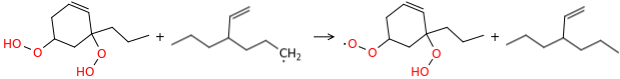

S(8357) + C9H17(300) <=> S(22630) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.6e+02
Violation condition: 1500 K, 1.0 bar




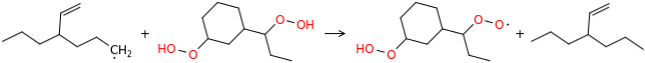

C9H17(300) + S(7447) <=> S(7445) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.5e+02
Violation condition: 1500 K, 1.0 bar




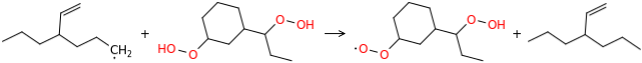

C9H17(300) + S(7447) <=> S(7411) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.5e+02
Violation condition: 1500 K, 1.0 bar




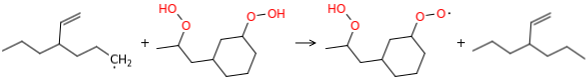

C9H17(300) + S(12617) <=> S(12593) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.5e+02
Violation condition: 1500 K, 1.0 bar




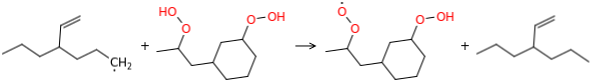

C9H17(300) + S(12617) <=> S(12641) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.5e+02
Violation condition: 1500 K, 1.0 bar




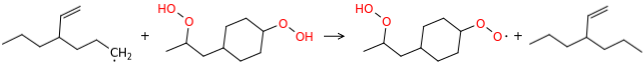

C9H17(300) + S(12722) <=> S(12704) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.5e+02
Violation condition: 1500 K, 1.0 bar




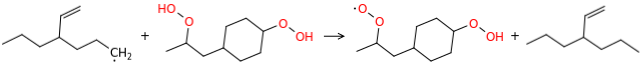

C9H17(300) + S(12722) <=> S(12747) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.5e+02
Violation condition: 1500 K, 1.0 bar




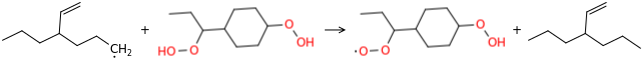

C9H17(300) + S(12791) <=> S(12803) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.5e+02
Violation condition: 1500 K, 1.0 bar




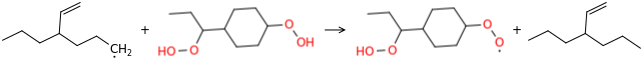

C9H17(300) + S(12791) <=> S(12771) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.5e+02
Violation condition: 1500 K, 1.0 bar




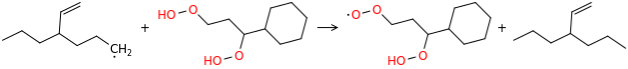

C9H17(300) + S(8280) <=> S(8066) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.5e+02
Violation condition: 1500 K, 1.0 bar




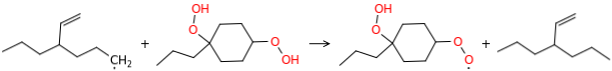

C9H17(300) + S(7096) <=> S(7055) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.5e+02
Violation condition: 1500 K, 1.0 bar




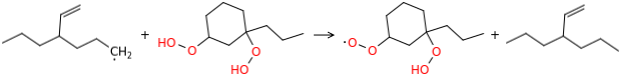

C9H17(300) + S(3463) <=> S(3462) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.5e+02
Violation condition: 1500 K, 1.0 bar




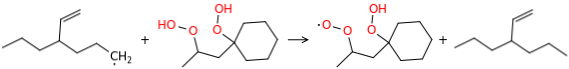

C9H17(300) + S(4571) <=> S(4570) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 3.4e+02
Violation condition: 1500 K, 1.0 bar




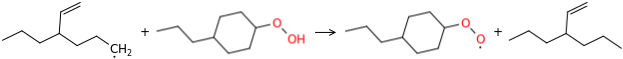

C9H17(300) + S(2160) <=> S(380) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 2.5e+02
Violation condition: 1500 K, 1.0 bar




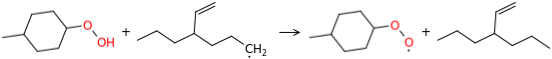

S(2772) + C9H17(300) <=> S(374) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 2.1e+02
Violation condition: 1500 K, 1.0 bar




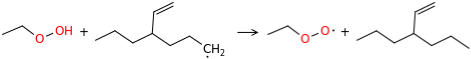

S(109) + C9H17(300) <=> C2H5O2(86) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 2e+02
Violation condition: 1500 K, 1.0 bar




C2H2(80) <=> H(12) + C2H(3)
ThirdBody(arrheniusLow=Arrhenius(A=(9.1e+30,'cm^3/(mol*s)'), n=-3.7, Ea=(127.138,'kcal/mol'), T0=(1,'K')), efficiencies={Molecule(smiles="[C-]#[O+]"): 2.0, Molecule(smiles="[H][H]"): 2.0, Molecule(smiles="O=C=O"): 3.0, Molecule(smiles="O"): 5.0})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1.4e+02
Violation condition: 500 K, 1.0 bar




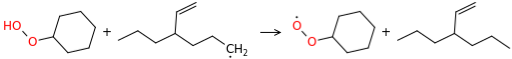

S(7054) + C9H17(300) <=> S(363) + C9H18(14)
Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Direction: reverse
Violation factor: 1.1e+02
Violation condition: 1500 K, 1.0 bar




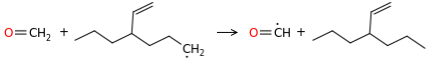

CH2O(6) + C9H17(300) <=> HCO(68) + C9H18(14)
Arrhenius(A=(5500,'cm^3/(mol*s)'), n=2.81, Ea=(5.86,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [CO_pri;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Direction: reverse
Violation factor: 54
Violation condition: 1500 K, 1.0 bar




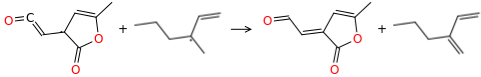

S(33407) + C7H13(358) <=> S(33131) + C7H12(295)
Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Estimated using template [CO_rad;XH_s_Rrad] for rate rule [CO_rad/OneDe;Cmethyl_Csrad]
Euclidian distance = 2.8284271247461903
Multiplied by reaction path degeneracy 3.0
family: Disproportionation
Direction: reverse
Violation factor: 52
Violation condition: 1500 K, 1.0 bar




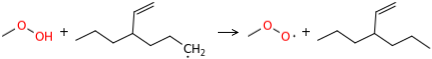

CH3OOH(81) + C9H17(300) <=> CH3OO(75) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [O/H/NonDeO;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 48
Violation condition: 1500 K, 1.0 bar




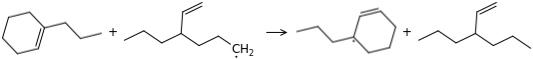

C9H16(27) + C9H17(300) <=> S(2806) + C9H18(14)
Arrhenius(A=(0.001806,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Direction: reverse
Violation factor: 33
Violation condition: 1500 K, 1.0 bar




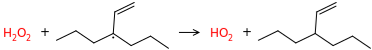

H2O2(23) + C9H17(309) <=> HO2_1(22) + C9H18(14)
Arrhenius(A=(10.0342,'cm^3/(mol*s)'), n=3.18, Ea=(1.786,'kcal/mol'), T0=(1,'K'))
Estimated using template [H2O2;C_ter_rad] for rate rule [H2O2;C_rad/CdCs2]
Euclidian distance = 3.0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Direction: reverse
Violation factor: 32
Violation condition: 1500 K, 1.0 bar




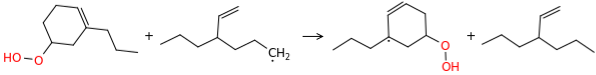

S(3416) + C9H17(300) <=> S(8208) + C9H18(14)
Arrhenius(A=(0.001806,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Direction: reverse
Violation factor: 30
Violation condition: 1500 K, 1.0 bar




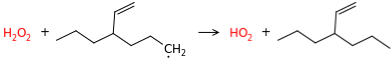

H2O2(23) + C9H17(300) <=> HO2_1(22) + C9H18(14)
Arrhenius(A=(1.7739,'cm^3/(mol*s)'), n=3.328, Ea=(1.143,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [H2O2;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Direction: reverse
Violation factor: 21
Violation condition: 1500 K, 1.0 bar




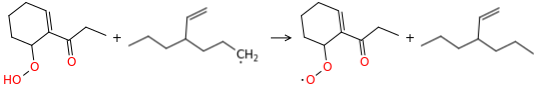

S(32038) + C9H17(300) <=> S(32125) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [O/H/NonDeO;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 21
Violation condition: 1500 K, 1.0 bar




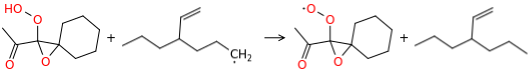

S(21412) + C9H17(300) <=> S(21407) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [O/H/NonDeO;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 19
Violation condition: 1500 K, 1.0 bar




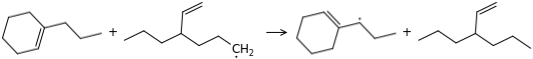

C9H16(27) + C9H17(300) <=> S(2791) + C9H18(14)
Arrhenius(A=(0.001806,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Direction: reverse
Violation factor: 18
Violation condition: 1500 K, 1.0 bar




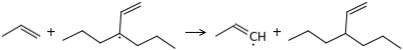

C3H6(8) + C9H17(309) <=> C3H5(123) + C9H18(14)
Arrhenius(A=(0.00666,'cm^3/(mol*s)'), n=4.34, Ea=(25.7,'kcal/mol'), T0=(1,'K'))
From training reaction 1572 used for Cd/H2/NonDeC;C_rad/CdCs2
Exact match found for rate rule [Cd/H2/NonDeC;C_rad/CdCs2]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Direction: reverse
Violation factor: 14
Violation condition: 1500 K, 1.0 bar




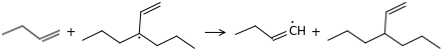

C4H81(132) + C9H17(309) <=> C4H7(486) + C9H18(14)
Arrhenius(A=(0.00666,'cm^3/(mol*s)'), n=4.34, Ea=(25.7,'kcal/mol'), T0=(1,'K'))
From training reaction 1572 used for Cd/H2/NonDeC;C_rad/CdCs2
Exact match found for rate rule [Cd/H2/NonDeC;C_rad/CdCs2]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Direction: reverse
Violation factor: 13
Violation condition: 1500 K, 1.0 bar




OH(11) + aC3H5(124) <=> H(12) + H(12) + C3H4O(127)
Arrhenius(A=(4.2e+32,'cm^3/(mol*s)'), n=-5.16, Ea=(30.126,'kcal/mol'), T0=(1,'K'))
Kinetic library: JetSurF2.0
Direction: reverse
Violation factor: 13
Violation condition: 500 K, 1.0 bar




CH2(69) <=> H(12) + CH(2)
ThirdBody(arrheniusLow=Arrhenius(A=(5.6e+15,'cm^3/(mol*s)'), n=0, Ea=(89,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 11
Violation condition: 500 K, 1.0 bar




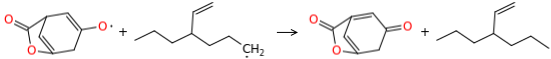

S(34631) + C9H17(300) <=> S(33879) + C9H18(14)
Arrhenius(A=(8.43e+11,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Estimated using template [C_rad/H2/Cs;Csec_Rrad] for rate rule [C_rad/H2/Cs;C/H/DeDe_Csrad]
Euclidian distance = 2.0
family: Disproportionation
Direction: reverse
Violation factor: 11
Violation condition: 1500 K, 1.0 bar




C2O(100) <=> C(79) + CO(4)
ThirdBody(arrheniusLow=Arrhenius(A=(2e+15,'cm^3/(mol*s)'), n=0, Ea=(44.2,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 10
Violation condition: 500 K, 40.0 bar




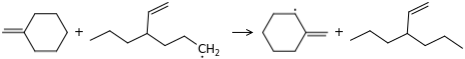

C7H12(32) + C9H17(300) <=> S(1090) + C9H18(14)
Arrhenius(A=(0.003612,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 4.0
family: H_Abstraction
Direction: reverse
Violation factor: 10
Violation condition: 1500 K, 1.0 bar




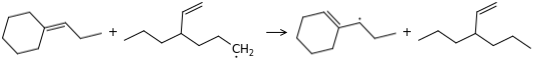

C9H16(26) + C9H17(300) <=> S(2791) + C9H18(14)
Arrhenius(A=(0.003612,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 4.0
family: H_Abstraction
Direction: reverse
Violation factor: 8.4
Violation condition: 1500 K, 1.0 bar




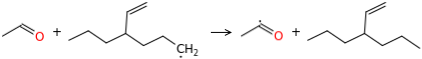

CH3CHO(84) + C9H17(300) <=> CH3CO(104) + C9H18(14)
Arrhenius(A=(3.8e+11,'cm^3/(mol*s)'), n=0, Ea=(7.21,'kcal/mol'), T0=(1,'K'))
Estimated using template [CO/H/Cs;C_pri_rad] for rate rule [CO/H/Cs;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Direction: reverse
Violation factor: 7.8
Violation condition: 1500 K, 1.0 bar




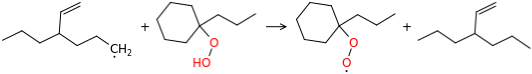

C9H17(300) + S(3024) <=> S(2723) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 7.6
Violation condition: 1500 K, 1.0 bar




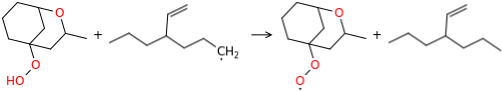

S(4598) + C9H17(300) <=> S(4613) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 7.5
Violation condition: 1500 K, 1.0 bar




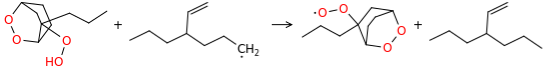

S(21957) + C9H17(300) <=> S(21935) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 7.5
Violation condition: 1500 K, 1.0 bar




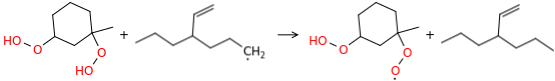

S(10185) + C9H17(300) <=> S(10167) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 7.4
Violation condition: 1500 K, 1.0 bar




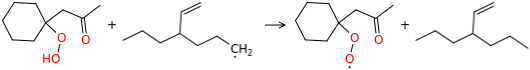

S(8392) + C9H17(300) <=> S(8416) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 7.4
Violation condition: 1500 K, 1.0 bar




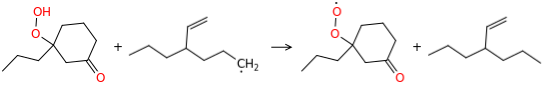

S(3467) + C9H17(300) <=> S(3513) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 7.4
Violation condition: 1500 K, 1.0 bar




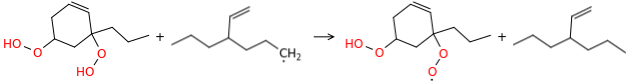

S(8357) + C9H17(300) <=> S(22631) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [O/H/NonDeO;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 7.2
Violation condition: 1500 K, 1.0 bar




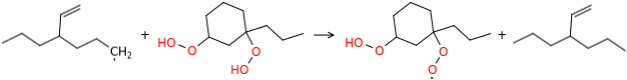

C9H17(300) + S(3463) <=> S(3437) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 7
Violation condition: 1500 K, 1.0 bar




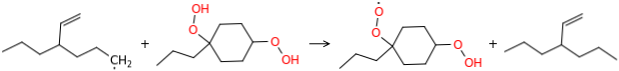

C9H17(300) + S(7096) <=> S(7094) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 7
Violation condition: 1500 K, 1.0 bar




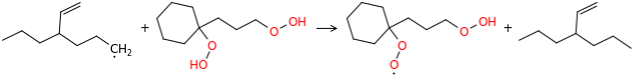

C9H17(300) + S(9684) <=> S(9667) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 6.9
Violation condition: 1500 K, 1.0 bar




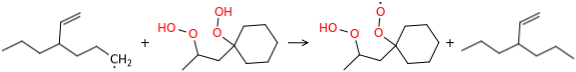

C9H17(300) + S(4571) <=> S(4552) + C9H18(14)
Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'))
Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Direction: reverse
Violation factor: 6.9
Violation condition: 1500 K, 1.0 bar




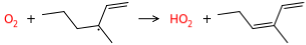

O2(13) + C7H13(358) <=> HO2_1(22) + S(8847)
Arrhenius(A=(1.833e+13,'cm^3/(mol*s)'), n=0, Ea=(14.85,'kcal/mol'), T0=(1,'K'))
From training reaction 15 used for O2b;C/H2/Nd_Csrad
Exact match found for rate rule [O2b;C/H2/Nd_Csrad]
Euclidian distance = 0
Multiplied by reaction path degeneracy 4.0
family: Disproportionation
Direction: reverse
Violation factor: 5.8
Violation condition: 1500 K, 1.0 bar




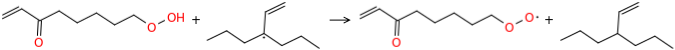

S(28969) + C9H17(309) <=> S(28962) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.6
Violation condition: 1500 K, 1.0 bar




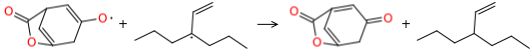

S(34631) + C9H17(309) <=> S(33879) + C9H18(14)
Arrhenius(A=(1.08e+14,'cm^3/(mol*s)'), n=-0.75, Ea=(0,'kcal/mol'), T0=(1,'K'))
Estimated using template [C_ter_rad;Csec_Rrad] for rate rule [C_rad/Cs2;C/H/DeDe_Csrad]
Euclidian distance = 2.8284271247461903
family: Disproportionation
Direction: reverse
Violation factor: 5.6
Violation condition: 1500 K, 1.0 bar




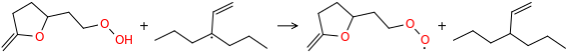

S(37526) + C9H17(309) <=> S(37521) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.5
Violation condition: 1500 K, 1.0 bar




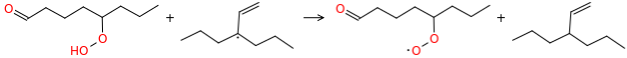

S(44703) + C9H17(309) <=> S(44700) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.4
Violation condition: 1500 K, 1.0 bar




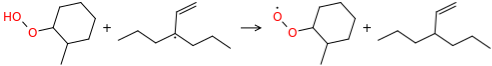

S(10510) + C9H17(309) <=> S(2729) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.4
Violation condition: 1500 K, 1.0 bar




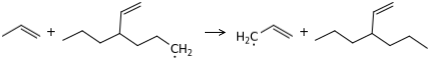

C3H6(8) + C9H17(300) <=> aC3H5(124) + C9H18(14)
Arrhenius(A=(0.000296135,'cm^3/(mol*s)'), n=4.545, Ea=(4.565,'kcal/mol'), T0=(1,'K'))
Estimated using an average for rate rule [C/H3/Cd\H_Cd\H2;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.4
Violation condition: 1500 K, 1.0 bar




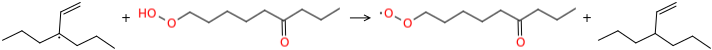

C9H17(309) + S(46389) <=> S(46386) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.3
Violation condition: 1500 K, 1.0 bar




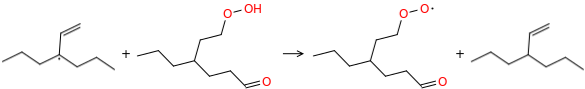

C9H17(309) + S(4131) <=> S(4128) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.3
Violation condition: 1500 K, 1.0 bar




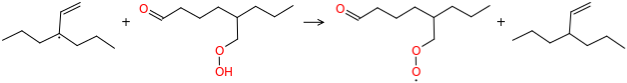

C9H17(309) + S(26883) <=> S(26880) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.3
Violation condition: 1500 K, 1.0 bar




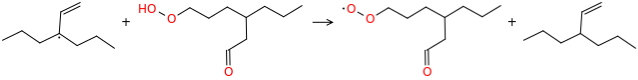

C9H17(309) + S(28231) <=> S(28198) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.3
Violation condition: 1500 K, 1.0 bar




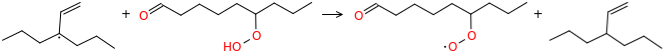

C9H17(309) + S(45578) <=> S(45575) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.3
Violation condition: 1500 K, 1.0 bar




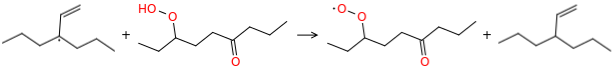

C9H17(309) + S(19484) <=> S(19473) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.2
Violation condition: 1500 K, 1.0 bar




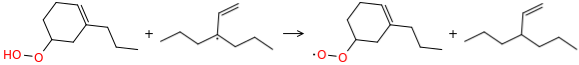

S(3416) + C9H17(309) <=> S(8199) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.2
Violation condition: 1500 K, 1.0 bar




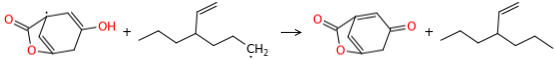

S(34630) + C9H17(300) <=> S(33879) + C9H18(14)
Arrhenius(A=(2.41e+12,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
From training reaction 58 used for C_rad/H2/Cs;O_Csrad
Exact match found for rate rule [C_rad/H2/Cs;O_Csrad]
Euclidian distance = 0
family: Disproportionation
Direction: reverse
Violation factor: 5.2
Violation condition: 1500 K, 1.0 bar




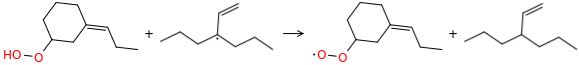

S(3415) + C9H17(309) <=> S(9447) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.2
Violation condition: 1500 K, 1.0 bar




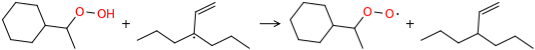

S(3271) + C9H17(309) <=> S(2734) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.2
Violation condition: 1500 K, 1.0 bar




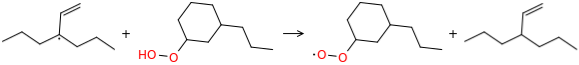

C9H17(309) + S(3113) <=> S(2727) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.2
Violation condition: 1500 K, 1.0 bar




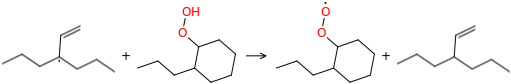

C9H17(309) + S(3210) <=> S(2722) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.2
Violation condition: 1500 K, 1.0 bar




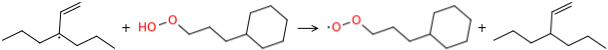

C9H17(309) + S(7578) <=> S(2726) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.1
Violation condition: 1500 K, 1.0 bar




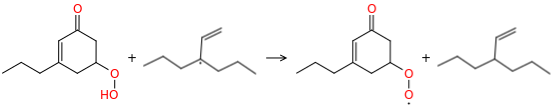

S(10012) + C9H17(309) <=> S(10901) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.1
Violation condition: 1500 K, 1.0 bar




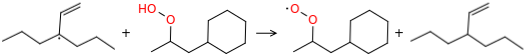

C9H17(309) + S(3151) <=> S(2725) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.1
Violation condition: 1500 K, 1.0 bar




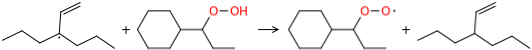

C9H17(309) + S(3265) <=> S(2724) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.1
Violation condition: 1500 K, 1.0 bar




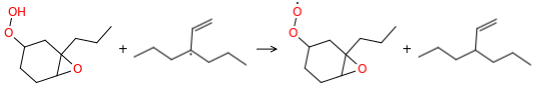

S(8117) + C9H17(309) <=> S(11576) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5.1
Violation condition: 1500 K, 1.0 bar




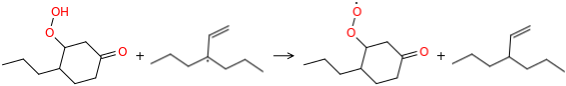

S(8431) + C9H17(309) <=> S(8508) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5
Violation condition: 1500 K, 1.0 bar




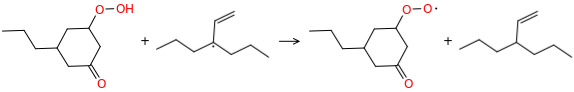

S(9815) + C9H17(309) <=> S(9816) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5
Violation condition: 1500 K, 1.0 bar




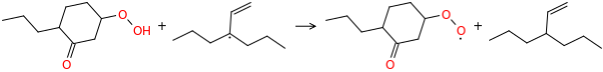

S(9130) + C9H17(309) <=> S(9208) + C9H18(14)
Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Direction: reverse
Violation factor: 5
Violation condition: 1500 K, 1.0 bar




In [17]:
families = Counter()
templates = Counter()
rate_rules = Counter()
problem_species = Counter()
for violator in violators:
    rxn_string = str(violator[0])
    kinetics = violator[0].kinetics
    comment = ''
    if isinstance(violator[0], TemplateReaction):
        comment = violator[0].kinetics.comment
        violator[0].kinetics.comment = ''  # the comment is printed better when outside of the object
    if isinstance(violator[0], LibraryReaction):
        comment = 'Kinetic library: {0}'.format(violator[0].library)
    if isinstance(violator[0], PDepReaction):
        comment = 'Network #{0}'.format(violator[0].network)
    direction = violator[1]
    ratio = violator[2]
    condition = violator[3]
    
    problem_species.update(violator[0].reactants)
    problem_species.update(violator[0].products)
    
    m = re.search('family: (.*)', comment)
    if m:
        families[m.group(1)] += 1
    n = re.search('rate rule (.*)', comment)
    if n:
        rate_rules[m.group(1) + n.group(1)] += 1
    n = re.search('using template (\S+)', comment)
    if n:
        templates[m.group(1) + n.group(1)] += 1
    
    if ratio < 5:
        continue # only print the big ones!
    
    display(violator[0])
    print('{0}\n{1}\n{2}\nDirection: {3}\nViolation factor: {4:.2g}\n'
                      'Violation condition: {5}\n\n'.format(rxn_string, kinetics, comment, direction,
                                                            ratio, condition))
    if isinstance(violator[0], TemplateReaction):
        # although this is the end of the run, restore the original comment
        violator[0].kinetics.comment = comment

In [18]:
families.most_common(10)

[('H_Abstraction', 137), ('Disproportionation', 55), ('R_Recombination', 1)]

In [19]:
# This is what was used
templates.most_common(10)

[('Disproportionation[CO_rad;XH_s_Rrad]', 42),
 ('H_Abstraction[ROOH_sec;C_ter_rad]', 38),
 ('H_Abstraction[O/H/NonDeO;C_rad/H2/Cs]', 10),
 ('H_Abstraction[ROOH_pri;C_ter_rad]', 10),
 ('H_Abstraction[O/H/NonDeO;C_ter_rad]', 10),
 ('Disproportionation[CO_pri_rad;XH_s_Rrad]', 2),
 ('Disproportionation[C_rad/H2/Cs;C/H/NdNd_Rrad]', 1),
 ('Disproportionation[C_ter_rad;C/H/NdNd_Rrad]', 1),
 ('H_Abstraction[H2O2;C_ter_rad]', 1),
 ('Disproportionation[C_rad/H2/Cs;Csec_Rrad]', 1)]

In [20]:
# This is what it was trying to use
rate_rules.most_common(10)

[('H_Abstraction[ROOH_sec;C_rad/H2/Cs]', 38),
 ('H_Abstraction[ROOH_sec;C_rad/CdCs2]', 38),
 ('Disproportionation[CO_rad/NonDe;Cmethyl_Csrad]', 21),
 ('H_Abstraction[ROOH_pri;C_rad/H2/Cs]', 10),
 ('Disproportionation[CO_rad/OneDe;Cmethyl_Csrad]', 10),
 ('H_Abstraction[ROOH_ter;C_rad/H2/Cs]', 10),
 ('H_Abstraction[ROOH_pri;C_rad/CdCs2]', 10),
 ('H_Abstraction[ROOH_ter;C_rad/CdCs2]', 10),
 ('H_Abstraction[C/H2/CdCs;C_rad/H2/Cs]', 6),
 ('H_Abstraction[O/H/NonDeO;C_rad/H2/Cs]', 4)]

In [21]:
# Most common species
for s,n in problem_species.most_common(20):
    print(f"{str(s):10s}  {n:3d}  {s.thermo.comment[:40]}")

C9H18(14)   144  Thermo group additivity estimation: grou
C9H17(300)   79  Thermo library: JetSurF2.0
C9H17(309)   67  Thermo library: JetSurF2.0
CH3CO(104)   33  Thermo library: Klippenstein_Glarborg201
CH3CHO(84)   24  Thermo library: Klippenstein_Glarborg201
HOCO(67)     24  Thermo library: Klippenstein_Glarborg201
HOCHO(106)   24  Thermo library: Klippenstein_Glarborg201
H(12)        16  Thermo library: BurkeH2O2
OCHCO(108)   15  Thermo library: Klippenstein_Glarborg201
OCHCHO(95)   15  Thermo library: Klippenstein_Glarborg201
CH2O(6)      13  Thermo library: Klippenstein_Glarborg201
S(33407)     12  Thermo group additivity estimation: grou
C3H6(8)      11  Thermo library: CurranPentane
S(33131)      9  Thermo group additivity estimation: grou
CH2CO(76)     9  Thermo library: Klippenstein_Glarborg201
HO2_1(22)     8  Thermo library: BurkeH2O2
C7H13(358)    8  Thermo library: JetSurF2.0
C7H12(295)    8  Thermo library: JetSurF2.0
C3H7(59)      8  Thermo library: CurranPentane
C2H4O(

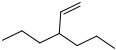

C9H18(14)
1  C u0 p0 c0 {2,S} {3,S} {8,S} {10,S}
2  C u0 p0 c0 {1,S} {4,S} {11,S} {12,S}
3  C u0 p0 c0 {1,S} {5,S} {15,S} {16,S}
4  C u0 p0 c0 {2,S} {6,S} {13,S} {14,S}
5  C u0 p0 c0 {3,S} {7,S} {17,S} {18,S}
6  C u0 p0 c0 {4,S} {19,S} {20,S} {21,S}
7  C u0 p0 c0 {5,S} {22,S} {23,S} {24,S}
8  C u0 p0 c0 {1,S} {9,D} {25,S}
9  C u0 p0 c0 {8,D} {26,S} {27,S}
10 H u0 p0 c0 {1,S}
11 H u0 p0 c0 {2,S}
12 H u0 p0 c0 {2,S}
13 H u0 p0 c0 {4,S}
14 H u0 p0 c0 {4,S}
15 H u0 p0 c0 {3,S}
16 H u0 p0 c0 {3,S}
17 H u0 p0 c0 {5,S}
18 H u0 p0 c0 {5,S}
19 H u0 p0 c0 {6,S}
20 H u0 p0 c0 {6,S}
21 H u0 p0 c0 {6,S}
22 H u0 p0 c0 {7,S}
23 H u0 p0 c0 {7,S}
24 H u0 p0 c0 {7,S}
25 H u0 p0 c0 {8,S}
26 H u0 p0 c0 {9,S}
27 H u0 p0 c0 {9,S}

Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + group(Cs-CsCsHH) + group(Cs-CsCsHH) + group(Cs-CsCsHH) + group(Cs-CsCsHH) + group(Cs-
CsHHH) + group(Cs-CsHHH) + group(Cds-CdsCsH) + group(Cds-CdsHH)
--------------------------------------------------------------------

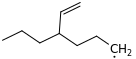

C9H17(300)
multiplicity 2
1  C u0 p0 c0 {2,S} {3,S} {7,S} {10,S}
2  C u0 p0 c0 {1,S} {4,S} {13,S} {14,S}
3  C u0 p0 c0 {1,S} {5,S} {11,S} {12,S}
4  C u0 p0 c0 {2,S} {6,S} {15,S} {16,S}
5  C u0 p0 c0 {3,S} {8,S} {17,S} {18,S}
6  C u0 p0 c0 {4,S} {19,S} {20,S} {21,S}
7  C u0 p0 c0 {1,S} {9,D} {22,S}
8  C u1 p0 c0 {5,S} {23,S} {24,S}
9  C u0 p0 c0 {7,D} {25,S} {26,S}
10 H u0 p0 c0 {1,S}
11 H u0 p0 c0 {3,S}
12 H u0 p0 c0 {3,S}
13 H u0 p0 c0 {2,S}
14 H u0 p0 c0 {2,S}
15 H u0 p0 c0 {4,S}
16 H u0 p0 c0 {4,S}
17 H u0 p0 c0 {5,S}
18 H u0 p0 c0 {5,S}
19 H u0 p0 c0 {6,S}
20 H u0 p0 c0 {6,S}
21 H u0 p0 c0 {6,S}
22 H u0 p0 c0 {7,S}
23 H u0 p0 c0 {8,S}
24 H u0 p0 c0 {8,S}
25 H u0 p0 c0 {9,S}
26 H u0 p0 c0 {9,S}

Thermo library: JetSurF2.0
--------------------------------------------------------------------------------


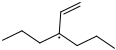

C9H17(309)
multiplicity 2
1  C u0 p0 c0 {3,S} {5,S} {10,S} {11,S}
2  C u0 p0 c0 {4,S} {6,S} {12,S} {13,S}
3  C u0 p0 c0 {1,S} {7,S} {14,S} {15,S}
4  C u0 p0 c0 {2,S} {7,S} {16,S} {17,S}
5  C u0 p0 c0 {1,S} {18,S} {19,S} {20,S}
6  C u0 p0 c0 {2,S} {21,S} {22,S} {23,S}
7  C u1 p0 c0 {3,S} {4,S} {8,S}
8  C u0 p0 c0 {7,S} {9,D} {24,S}
9  C u0 p0 c0 {8,D} {25,S} {26,S}
10 H u0 p0 c0 {1,S}
11 H u0 p0 c0 {1,S}
12 H u0 p0 c0 {2,S}
13 H u0 p0 c0 {2,S}
14 H u0 p0 c0 {3,S}
15 H u0 p0 c0 {3,S}
16 H u0 p0 c0 {4,S}
17 H u0 p0 c0 {4,S}
18 H u0 p0 c0 {5,S}
19 H u0 p0 c0 {5,S}
20 H u0 p0 c0 {5,S}
21 H u0 p0 c0 {6,S}
22 H u0 p0 c0 {6,S}
23 H u0 p0 c0 {6,S}
24 H u0 p0 c0 {8,S}
25 H u0 p0 c0 {9,S}
26 H u0 p0 c0 {9,S}

Thermo library: JetSurF2.0
--------------------------------------------------------------------------------


CH3CO(104)
multiplicity 2
1 O u0 p2 c0 {3,D}
2 C u0 p0 c0 {3,S} {4,S} {5,S} {6,S}
3 C u1 p0 c0 {1,D} {2,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {2,S}
6 H u0 p0 c0 {2,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


CH3CHO(84)
1 O u0 p2 c0 {3,D}
2 C u0 p0 c0 {3,S} {4,S} {5,S} {6,S}
3 C u0 p0 c0 {1,D} {2,S} {7,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {2,S}
6 H u0 p0 c0 {2,S}
7 H u0 p0 c0 {3,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


HOCO(67)
multiplicity 2
1 O u0 p2 c0 {3,S} {4,S}
2 O u0 p2 c0 {3,D}
3 C u1 p0 c0 {1,S} {2,D}
4 H u0 p0 c0 {1,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


HOCHO(106)
1 O u0 p2 c0 {3,S} {5,S}
2 O u0 p2 c0 {3,D}
3 C u0 p0 c0 {1,S} {2,D} {4,S}
4 H u0 p0 c0 {3,S}
5 H u0 p0 c0 {1,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


H(12)
multiplicity 2
1 H u1 p0 c0

Thermo library: BurkeH2O2
--------------------------------------------------------------------------------


OCHCO(108)
multiplicity 2
1 O u1 p2 c0 {3,S}
2 O u0 p2 c0 {4,D}
3 C u0 p0 c0 {1,S} {4,D} {5,S}
4 C u0 p0 c0 {2,D} {3,D}
5 H u0 p0 c0 {3,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


OCHCHO(95)
1 O u0 p2 c0 {3,D}
2 O u0 p2 c0 {4,D}
3 C u0 p0 c0 {1,D} {4,S} {5,S}
4 C u0 p0 c0 {2,D} {3,S} {6,S}
5 H u0 p0 c0 {3,S}
6 H u0 p0 c0 {4,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


CH2O(6)
1 O u0 p2 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,S} {4,S}
3 H u0 p0 c0 {2,S}
4 H u0 p0 c0 {2,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


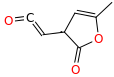

S(33407)
multiplicity 2
1  O u0 p2 c0 {6,S} {8,S}
2  O u0 p2 c0 {8,D}
3  O u0 p2 c0 {10,D}
4  C u0 p0 c0 {6,S} {11,S} {12,S} {13,S}
5  C u1 p0 c0 {7,S} {8,S} {9,S}
6  C u0 p0 c0 {1,S} {4,S} {7,D}
7  C u0 p0 c0 {5,S} {6,D} {14,S}
8  C u0 p0 c0 {1,S} {2,D} {5,S}
9  C u0 p0 c0 {5,S} {10,D} {15,S}
10 C u0 p0 c0 {3,D} {9,D}
11 H u0 p0 c0 {4,S}
12 H u0 p0 c0 {4,S}
13 H u0 p0 c0 {4,S}
14 H u0 p0 c0 {7,S}
15 H u0 p0 c0 {9,S}

Thermo group additivity estimation: group(O2s-(Cds-O2d)(Cds-Cd)) + group(Cs-(Cds-Cdd-O2d)CsCsH) + group(Cs-(Cds-Cds)HHH) + group(Cds-CdsCsOs) +
group(Cds-CdsCsH) + group(Cds-OdCsOs) + group(Cds-(Cdd-O2d)CsH) + ring(Cyclopentane) + radical(CCJ(C)CO)
--------------------------------------------------------------------------------


C3H6(8)
1 C u0 p0 c0 {2,S} {4,S} {5,S} {6,S}
2 C u0 p0 c0 {1,S} {3,D} {7,S}
3 C u0 p0 c0 {2,D} {8,S} {9,S}
4 H u0 p0 c0 {1,S}
5 H u0 p0 c0 {1,S}
6 H u0 p0 c0 {1,S}
7 H u0 p0 c0 {2,S}
8 H u0 p0 c0 {3,S}
9 H u0 p0 c0 {3,S}

Thermo library: CurranPentane
--------------------------------------------------------------------------------


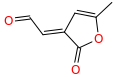

S(33131)
1  O u0 p2 c0 {6,S} {9,S}
2  O u0 p2 c0 {9,D}
3  O u0 p2 c0 {10,D}
4  C u0 p0 c0 {6,S} {11,S} {12,S} {13,S}
5  C u0 p0 c0 {7,S} {8,D} {9,S}
6  C u0 p0 c0 {1,S} {4,S} {7,D}
7  C u0 p0 c0 {5,S} {6,D} {15,S}
8  C u0 p0 c0 {5,D} {10,S} {14,S}
9  C u0 p0 c0 {1,S} {2,D} {5,S}
10 C u0 p0 c0 {3,D} {8,S} {16,S}
11 H u0 p0 c0 {4,S}
12 H u0 p0 c0 {4,S}
13 H u0 p0 c0 {4,S}
14 H u0 p0 c0 {8,S}
15 H u0 p0 c0 {7,S}
16 H u0 p0 c0 {10,S}

Thermo group additivity estimation: group(O2s-(Cds-O2d)(Cds-Cd)) + group(Cs-(Cds-Cds)HHH) + group(Cds-Cds(Cds-O2d)(Cds-Cds)) + group(Cds-CdsCsOs) +
group(Cds-Cds(Cds-Cds)H) + group(Cd-Cd(CO)H) + group(Cds-O2d(Cds-Cds)O2s) + group(Cds-O2d(Cds-Cds)H) + ring(Cyclopentane)
--------------------------------------------------------------------------------


CH2CO(76)
1 O u0 p2 c0 {3,D}
2 C u0 p0 c0 {3,D} {4,S} {5,S}
3 C u0 p0 c0 {1,D} {2,D}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {2,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


HO2_1(22)
multiplicity 2
1 O u0 p2 c0 {2,S} {3,S}
2 O u1 p2 c0 {1,S}
3 H u0 p0 c0 {1,S}

Thermo library: BurkeH2O2
--------------------------------------------------------------------------------


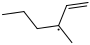

C7H13(358)
multiplicity 2
1  C u0 p0 c0 {2,S} {3,S} {8,S} {9,S}
2  C u0 p0 c0 {1,S} {5,S} {10,S} {11,S}
3  C u0 p0 c0 {1,S} {12,S} {13,S} {14,S}
4  C u0 p0 c0 {5,S} {15,S} {16,S} {17,S}
5  C u1 p0 c0 {2,S} {4,S} {6,S}
6  C u0 p0 c0 {5,S} {7,D} {18,S}
7  C u0 p0 c0 {6,D} {19,S} {20,S}
8  H u0 p0 c0 {1,S}
9  H u0 p0 c0 {1,S}
10 H u0 p0 c0 {2,S}
11 H u0 p0 c0 {2,S}
12 H u0 p0 c0 {3,S}
13 H u0 p0 c0 {3,S}
14 H u0 p0 c0 {3,S}
15 H u0 p0 c0 {4,S}
16 H u0 p0 c0 {4,S}
17 H u0 p0 c0 {4,S}
18 H u0 p0 c0 {6,S}
19 H u0 p0 c0 {7,S}
20 H u0 p0 c0 {7,S}

Thermo library: JetSurF2.0
--------------------------------------------------------------------------------


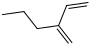

C7H12(295)
1  C u0 p0 c0 {2,S} {3,S} {8,S} {9,S}
2  C u0 p0 c0 {1,S} {4,S} {10,S} {11,S}
3  C u0 p0 c0 {1,S} {12,S} {13,S} {14,S}
4  C u0 p0 c0 {2,S} {5,S} {6,D}
5  C u0 p0 c0 {4,S} {7,D} {15,S}
6  C u0 p0 c0 {4,D} {18,S} {19,S}
7  C u0 p0 c0 {5,D} {16,S} {17,S}
8  H u0 p0 c0 {1,S}
9  H u0 p0 c0 {1,S}
10 H u0 p0 c0 {2,S}
11 H u0 p0 c0 {2,S}
12 H u0 p0 c0 {3,S}
13 H u0 p0 c0 {3,S}
14 H u0 p0 c0 {3,S}
15 H u0 p0 c0 {5,S}
16 H u0 p0 c0 {7,S}
17 H u0 p0 c0 {7,S}
18 H u0 p0 c0 {6,S}
19 H u0 p0 c0 {6,S}

Thermo library: JetSurF2.0
--------------------------------------------------------------------------------


C3H7(59)
multiplicity 2
1  C u0 p0 c0 {3,S} {4,S} {5,S} {6,S}
2  C u0 p0 c0 {3,S} {7,S} {8,S} {9,S}
3  C u1 p0 c0 {1,S} {2,S} {10,S}
4  H u0 p0 c0 {1,S}
5  H u0 p0 c0 {1,S}
6  H u0 p0 c0 {1,S}
7  H u0 p0 c0 {2,S}
8  H u0 p0 c0 {2,S}
9  H u0 p0 c0 {2,S}
10 H u0 p0 c0 {3,S}

Thermo library: CurranPentane
--------------------------------------------------------------------------------


C2H4O(89)
1 O u0 p2 c0 {2,S} {7,S}
2 C u0 p0 c0 {1,S} {3,D} {4,S}
3 C u0 p0 c0 {2,D} {5,S} {6,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {3,S}
6 H u0 p0 c0 {3,S}
7 H u0 p0 c0 {1,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


In [22]:
for s,n in problem_species.most_common(20):
    display(s)
    print(s)
    print(s.molecule[0].to_adjacency_list())
    print(s.thermo.comment)
    print('-'*80)

In [23]:
# species_dict.keys()
violators[2][0]

In [24]:
worst_offenders = dict()
for reaction, direction, ratio, condition  in violators:
    if reaction not in worst_offenders:
        worst_offenders[reaction] = (direction, ratio, condition)
    elif ratio > worst_offenders[reaction][1]:
        # This is now the worst
        worst_offenders[reaction] = (direction, ratio, condition)
        
worst_offenders

{LibraryReaction(index=583, reactants=[Species(index=6, label="CH2O", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[4.79372,-0.00990833,3.7322e-05,-3.79285e-08,1.31773e-11,-14379.2,0.602798], Tmin=(200,'K'), Tmax=(1000,'K')), NASAPolynomial(coeffs=[3.16953,0.00619321,-2.25056e-06,3.65976e-10,-2.20149e-14,-14548.7,6.04208], Tmin=(1000,'K'), Tmax=(6000,'K'))], Tmin=(200,'K'), Tmax=(6000,'K'), comment="""Thermo library: Klippenstein_Glarborg2016"""), molecule=[Molecule(smiles="C=O")], transport_data=TransportData(shapeIndex=2, epsilon=(4140.61,'J/mol'), sigma=(3.59,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=2.0, comment="""NOx2018"""), molecular_weight=(30.026,'amu')), Species(index=103, label="S", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[0.556418,0.0412519,-3.10647e-05,1.2293e-08,-1.99691e-12,-22047.4,24.9983], Tmin=(298,'K'), Tmax=(800,'K')), NASAPolynomial(coeffs=[0.556418,0.0412519,-3.10647e-05,1.2293e-08,-1.99691e-12,-22047.4,24.9983

Arrhenius(A=(41000,'cm^3/(mol*s)'), n=2.5, Ea=(10.206,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.28581e-14,'cm^3/(mol*s)'), n=2.5, Ea=(10.206,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.8e+18 to avoid reverse rate violating the collision limit at 500 K, 1.0 bar""")


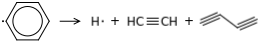

Arrhenius(A=(4.3e+12,'s^-1'), n=0.62, Ea=(77.294,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.47149,'s^-1'), n=0.62, Ea=(77.294,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.7e+12 to avoid reverse rate violating the collision limit at 500 K, 1.0 bar""")


ThirdBody(arrheniusLow=Arrhenius(A=(2.2e+15,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={})
ThirdBody(arrheniusLow=Arrhenius(A=(1.13044e+07,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={}, comment="""Reduced by a factor of 1.9e+08 to avoid reverse rate violating the collision limit at 500 K, 40.0 bar""")


Arrhenius(A=(2.5e+11,'cm^3/(mol*s)'), n=0, Ea=(-1.49,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2691.58,'cm^3/(mol*s)'), n=0, Ea=(-1.49,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 9.3e+07 to avoid reverse rate violating the collision limit at 500 K, 1.0 bar""")


ThirdBody(arrheniusLow=Arrhenius(A=(3.1e+15,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={})
ThirdBody(arrheniusLow=Arrhenius(A=(4.07251e+07,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={}, comment="""Reduced by a factor of 7.6e+07 to avoid reverse rate violating the collision limit at 500 K, 40.0 bar""")


ThirdBody(arrheniusLow=Arrhenius(A=(9.1e+30,'cm^3/(mol*s)'), n=-3.7, Ea=(127.138,'kcal/mol'), T0=(1,'K')), efficiencies={Molecule(smiles="[C-]#[O+]"): 2.0, Molecule(smiles="[H][H]"): 2.0, Molecule(smiles="O=C=O"): 3.0, Molecule(smiles="O"): 5.0})
ThirdBody(arrheniusLow=Arrhenius(A=(1.62203e+27,'cm^3/(mol*s)'), n=-3.7, Ea=(127.138,'kcal/mol'), T0=(1,'K')), efficiencies={Molecule(smiles="[C-]#[O+]"): 2.0, Molecule(smiles="[H][H]"): 2.0, Molecule(smiles="O=C=O"): 3.0, Molecule(smiles="O"): 5.0}, comment="""Reduced by a factor of 5.6e+03 to avoid reverse rate violating the collision limit at 500 K, 40.0 bar""")


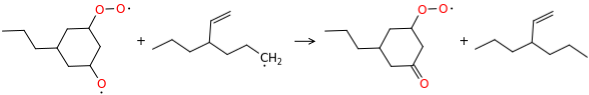

Arrhenius(A=(8.43e+11,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [C_rad/H2/Cs;C/H/NdNd_Rrad] for rate rule [C_rad/H2/Cs;C/H/NdNd_Orad]
Euclidian distance = 1.0
family: Disproportionation""")
Arrhenius(A=(1.23683e+09,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [C_rad/H2/Cs;C/H/NdNd_Rrad] for rate rule [C_rad/H2/Cs;C/H/NdNd_Orad]
Euclidian distance = 1.0
family: Disproportionation
Reduced by a factor of 6.8e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


ThirdBody(arrheniusLow=Arrhenius(A=(5.6e+15,'cm^3/(mol*s)'), n=0, Ea=(89,'kcal/mol'), T0=(1,'K')), efficiencies={})
ThirdBody(arrheniusLow=Arrhenius(A=(1.24261e+13,'cm^3/(mol*s)'), n=0, Ea=(89,'kcal/mol'), T0=(1,'K')), efficiencies={}, comment="""Reduced by a factor of 4.5e+02 to avoid reverse rate violating the collision limit at 500 K, 40.0 bar""")


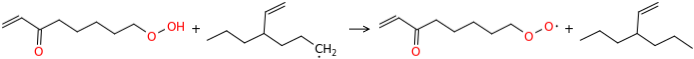

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(5.94115e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 4.2e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


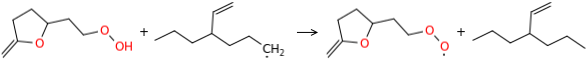

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(5.99921e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 4.2e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


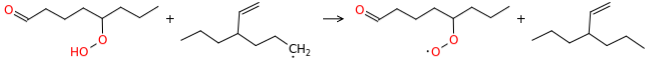

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.10462e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 4.1e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


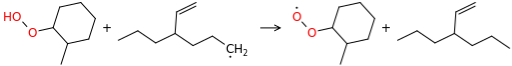

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.15395e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 4.1e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


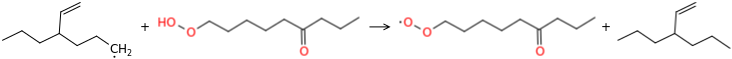

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.26707e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 4e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


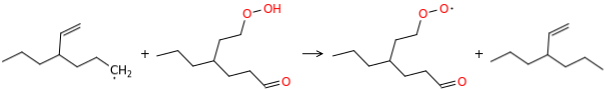

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.27707e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 4e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


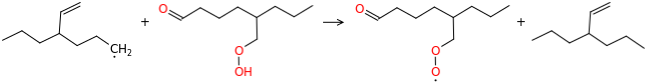

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.27707e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 4e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


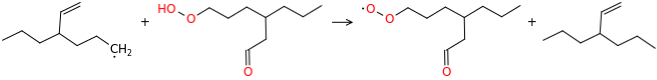

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.27707e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 4e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


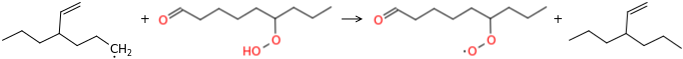

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.2802e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 4e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


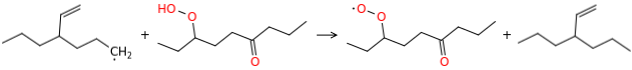

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.3345e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 4e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


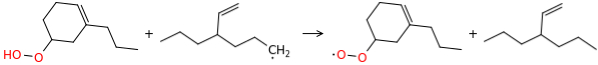

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.3561e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.9e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


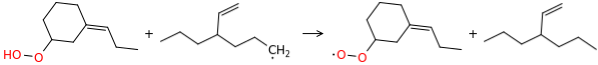

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.39733e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.9e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


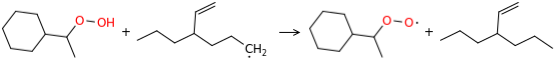

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.40914e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.9e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


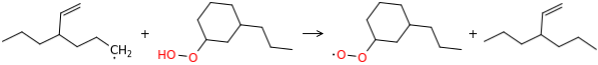

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.43947e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.9e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


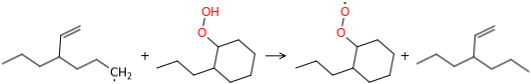

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.43947e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.9e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


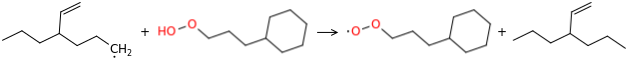

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.5289e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.8e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


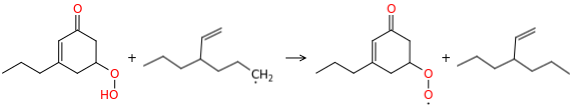

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.54578e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.8e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


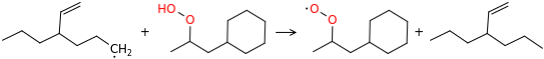

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.56065e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.8e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


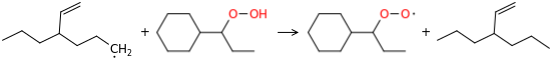

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.56065e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.8e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


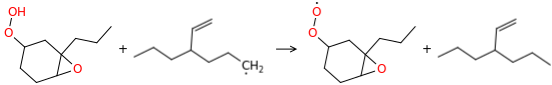

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.57076e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.8e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


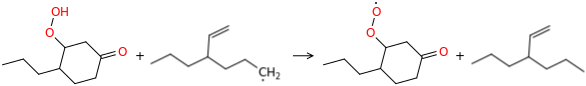

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.62074e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.8e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


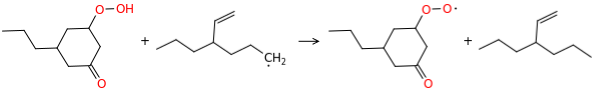

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.62074e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.8e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


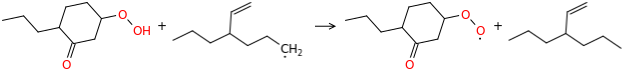

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.62237e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.8e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


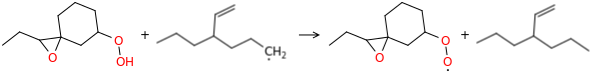

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.65632e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.8e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


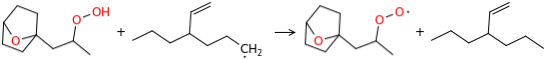

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.68886e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.8e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


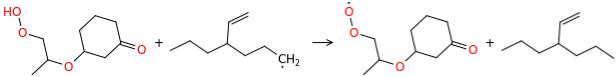

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.82698e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.7e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


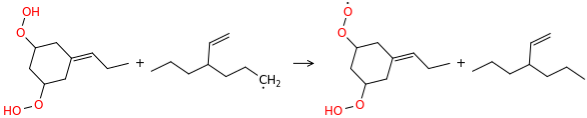

Arrhenius(A=(5.02e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(1.38337e-13,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.6e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


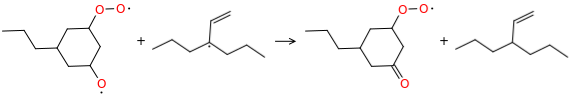

Arrhenius(A=(1.08e+14,'cm^3/(mol*s)'), n=-0.75, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [C_ter_rad;C/H/NdNd_Rrad] for rate rule [C_rad/Cs2;C/H/NdNd_Orad]
Euclidian distance = 2.23606797749979
family: Disproportionation""")
Arrhenius(A=(2.98112e+11,'cm^3/(mol*s)'), n=-0.75, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [C_ter_rad;C/H/NdNd_Rrad] for rate rule [C_rad/Cs2;C/H/NdNd_Orad]
Euclidian distance = 2.23606797749979
family: Disproportionation
Reduced by a factor of 3.6e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


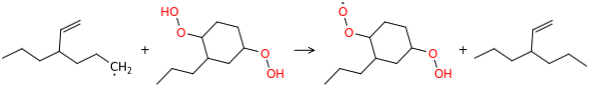

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.97695e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.6e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


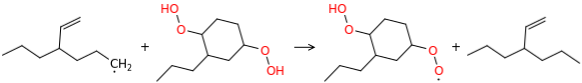

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.97695e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.6e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


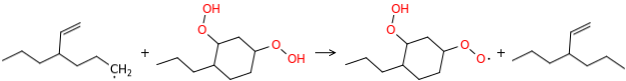

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.97695e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.6e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


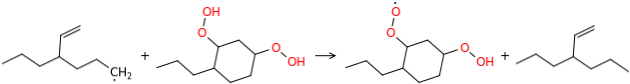

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(6.97695e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.6e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


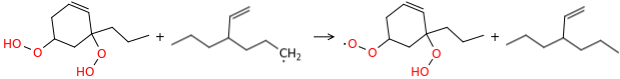

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.00612e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.6e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


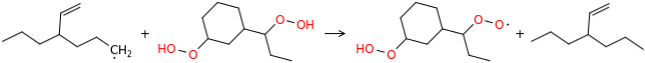

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.0974e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.5e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


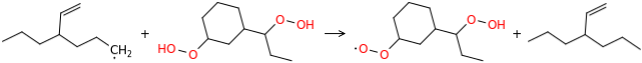

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.0974e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.5e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


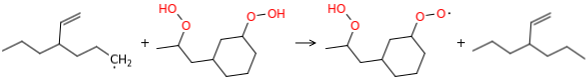

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.0974e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.5e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


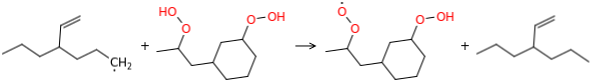

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.0974e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.5e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


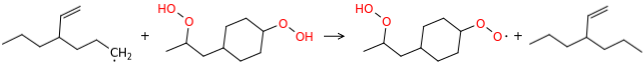

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.0974e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.5e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


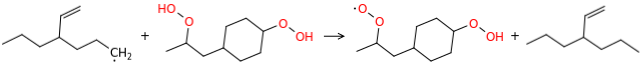

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.0974e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.5e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


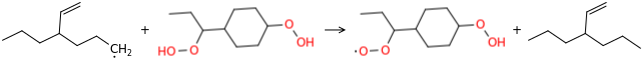

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.0974e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.5e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


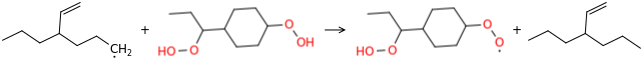

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.0974e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.5e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


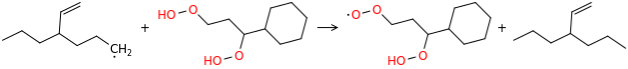

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.21485e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.5e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


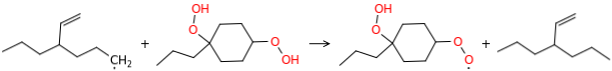

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.22021e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.5e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


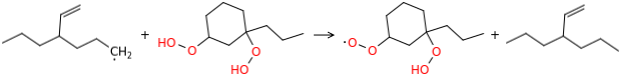

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.22021e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.5e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


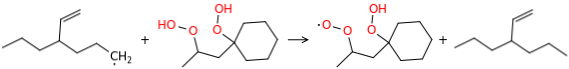

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(7.34331e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 3.4e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


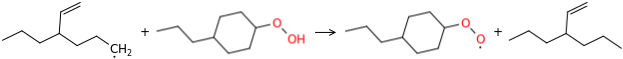

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(9.95253e-14,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 2.5e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


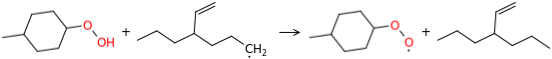

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(1.20569e-13,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 2.1e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


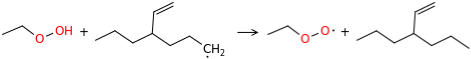

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(1.23321e-13,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_pri;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 2e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


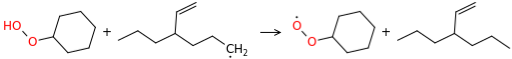

Arrhenius(A=(2.51e-11,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.""")
Arrhenius(A=(2.24793e-13,'cm^3/(mol*s)'), n=6.77, Ea=(-8.6,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [ROOH_sec;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -36.0 to -36.0 kJ/mol.
Reduced by a factor of 1.1e+02 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


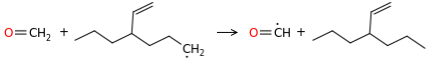

Arrhenius(A=(5500,'cm^3/(mol*s)'), n=2.81, Ea=(5.86,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [CO_pri;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction""")
Arrhenius(A=(102.793,'cm^3/(mol*s)'), n=2.81, Ea=(5.86,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [CO_pri;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Reduced by a factor of 54 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


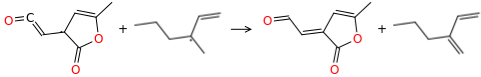

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [CO_rad;XH_s_Rrad] for rate rule [CO_rad/OneDe;Cmethyl_Csrad]
Euclidian distance = 2.8284271247461903
Multiplied by reaction path degeneracy 3.0
family: Disproportionation""")
Arrhenius(A=(1.04435e+13,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [CO_rad;XH_s_Rrad] for rate rule [CO_rad/OneDe;Cmethyl_Csrad]
Euclidian distance = 2.8284271247461903
Multiplied by reaction path degeneracy 3.0
family: Disproportionation
Reduced by a factor of 52 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


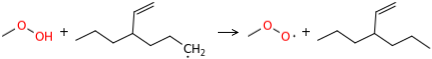

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [O/H/NonDeO;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(1.3278e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [O/H/NonDeO;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 48 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


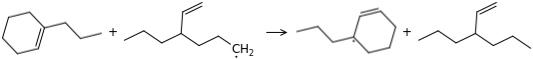

Arrhenius(A=(0.001806,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction""")
Arrhenius(A=(5.53349e-05,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Reduced by a factor of 33 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


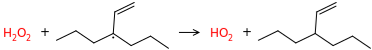

Arrhenius(A=(10.0342,'cm^3/(mol*s)'), n=3.18, Ea=(1.786,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [H2O2;C_ter_rad] for rate rule [H2O2;C_rad/CdCs2]
Euclidian distance = 3.0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction""")
Arrhenius(A=(0.309158,'cm^3/(mol*s)'), n=3.18, Ea=(1.786,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [H2O2;C_ter_rad] for rate rule [H2O2;C_rad/CdCs2]
Euclidian distance = 3.0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Reduced by a factor of 32 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


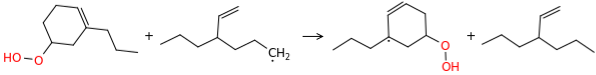

Arrhenius(A=(0.001806,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction""")
Arrhenius(A=(5.94239e-05,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Reduced by a factor of 30 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


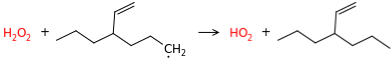

Arrhenius(A=(1.7739,'cm^3/(mol*s)'), n=3.328, Ea=(1.143,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [H2O2;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction""")
Arrhenius(A=(0.0844182,'cm^3/(mol*s)'), n=3.328, Ea=(1.143,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [H2O2;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Reduced by a factor of 21 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


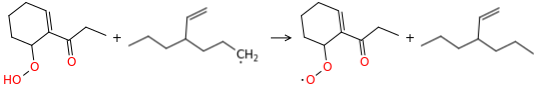

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [O/H/NonDeO;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(3.11264e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [O/H/NonDeO;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 21 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


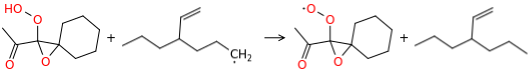

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [O/H/NonDeO;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(3.36956e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [O/H/NonDeO;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 19 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


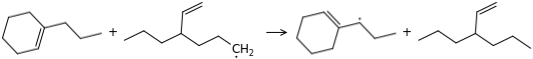

Arrhenius(A=(0.001806,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction""")
Arrhenius(A=(9.89535e-05,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Reduced by a factor of 18 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


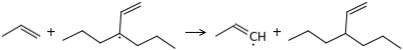

Arrhenius(A=(0.00666,'cm^3/(mol*s)'), n=4.34, Ea=(25.7,'kcal/mol'), T0=(1,'K'), comment="""From training reaction 1572 used for Cd/H2/NonDeC;C_rad/CdCs2
Exact match found for rate rule [Cd/H2/NonDeC;C_rad/CdCs2]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction""")
Arrhenius(A=(0.000467655,'cm^3/(mol*s)'), n=4.34, Ea=(25.7,'kcal/mol'), T0=(1,'K'), comment="""From training reaction 1572 used for Cd/H2/NonDeC;C_rad/CdCs2
Exact match found for rate rule [Cd/H2/NonDeC;C_rad/CdCs2]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Reduced by a factor of 14 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


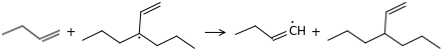

Arrhenius(A=(0.00666,'cm^3/(mol*s)'), n=4.34, Ea=(25.7,'kcal/mol'), T0=(1,'K'), comment="""From training reaction 1572 used for Cd/H2/NonDeC;C_rad/CdCs2
Exact match found for rate rule [Cd/H2/NonDeC;C_rad/CdCs2]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction""")
Arrhenius(A=(0.000518652,'cm^3/(mol*s)'), n=4.34, Ea=(25.7,'kcal/mol'), T0=(1,'K'), comment="""From training reaction 1572 used for Cd/H2/NonDeC;C_rad/CdCs2
Exact match found for rate rule [Cd/H2/NonDeC;C_rad/CdCs2]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: H_Abstraction
Reduced by a factor of 13 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


Arrhenius(A=(4.2e+32,'cm^3/(mol*s)'), n=-5.16, Ea=(30.126,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.30742e+31,'cm^3/(mol*s)'), n=-5.16, Ea=(30.126,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 13 to avoid reverse rate violating the collision limit at 500 K, 1.0 bar""")


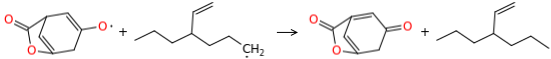

Arrhenius(A=(8.43e+11,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [C_rad/H2/Cs;Csec_Rrad] for rate rule [C_rad/H2/Cs;C/H/DeDe_Csrad]
Euclidian distance = 2.0
family: Disproportionation""")
Arrhenius(A=(8.01835e+10,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [C_rad/H2/Cs;Csec_Rrad] for rate rule [C_rad/H2/Cs;C/H/DeDe_Csrad]
Euclidian distance = 2.0
family: Disproportionation
Reduced by a factor of 11 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


ThirdBody(arrheniusLow=Arrhenius(A=(2e+15,'cm^3/(mol*s)'), n=0, Ea=(44.2,'kcal/mol'), T0=(1,'K')), efficiencies={})
ThirdBody(arrheniusLow=Arrhenius(A=(1.92457e+14,'cm^3/(mol*s)'), n=0, Ea=(44.2,'kcal/mol'), T0=(1,'K')), efficiencies={}, comment="""Reduced by a factor of 10 to avoid reverse rate violating the collision limit at 500 K, 40.0 bar""")


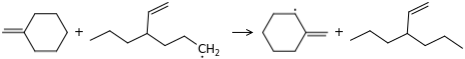

Arrhenius(A=(0.003612,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 4.0
family: H_Abstraction""")
Arrhenius(A=(0.000361336,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 4.0
family: H_Abstraction
Reduced by a factor of 10 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


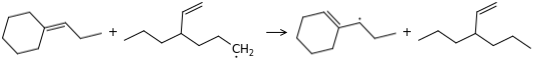

Arrhenius(A=(0.003612,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 4.0
family: H_Abstraction""")
Arrhenius(A=(0.000427681,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [C/H2/CdCs;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 4.0
family: H_Abstraction
Reduced by a factor of 8.4 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


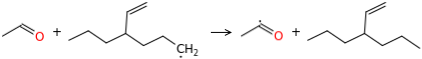

Arrhenius(A=(3.8e+11,'cm^3/(mol*s)'), n=0, Ea=(7.21,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [CO/H/Cs;C_pri_rad] for rate rule [CO/H/Cs;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction""")
Arrhenius(A=(4.90047e+10,'cm^3/(mol*s)'), n=0, Ea=(7.21,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [CO/H/Cs;C_pri_rad] for rate rule [CO/H/Cs;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Reduced by a factor of 7.8 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


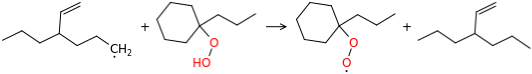

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(8.42054e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 7.6 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


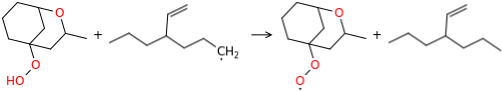

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(8.5644e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 7.5 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


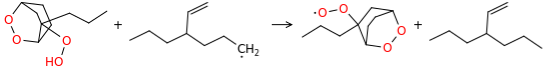

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(8.56751e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 7.5 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


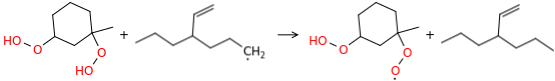

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(8.62888e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 7.4 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


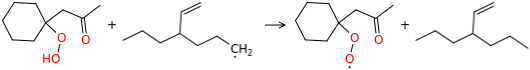

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(8.63092e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 7.4 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


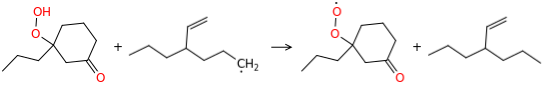

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(8.67093e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 7.4 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


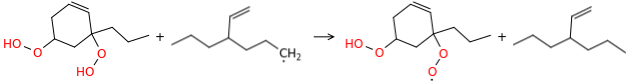

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [O/H/NonDeO;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(8.86552e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [O/H/NonDeO;C_rad/H2/Cs]
Euclidian distance = 0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 7.2 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


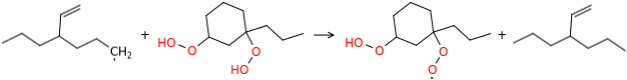

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(9.13642e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


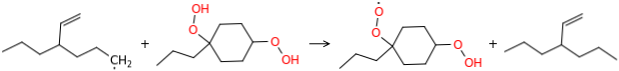

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(9.13642e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


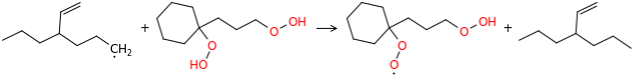

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(9.25849e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 6.9 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


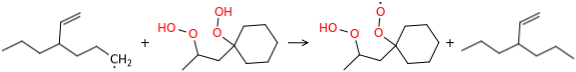

Arrhenius(A=(0.00063914,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.""")
Arrhenius(A=(9.2922e-05,'cm^3/(mol*s)'), n=4.352, Ea=(-1.737,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [O/H/NonDeO;C_rad/H2/Cs] for rate rule [ROOH_ter;C_rad/H2/Cs]
Euclidian distance = 1.0
family: H_Abstraction
Ea raised from -7.3 to -7.3 kJ/mol.
Reduced by a factor of 6.9 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


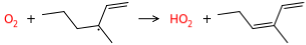

Arrhenius(A=(1.833e+13,'cm^3/(mol*s)'), n=0, Ea=(14.85,'kcal/mol'), T0=(1,'K'), comment="""From training reaction 15 used for O2b;C/H2/Nd_Csrad
Exact match found for rate rule [O2b;C/H2/Nd_Csrad]
Euclidian distance = 0
Multiplied by reaction path degeneracy 4.0
family: Disproportionation""")
Arrhenius(A=(3.17792e+12,'cm^3/(mol*s)'), n=0, Ea=(14.85,'kcal/mol'), T0=(1,'K'), comment="""From training reaction 15 used for O2b;C/H2/Nd_Csrad
Exact match found for rate rule [O2b;C/H2/Nd_Csrad]
Euclidian distance = 0
Multiplied by reaction path degeneracy 4.0
family: Disproportionation
Reduced by a factor of 5.8 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


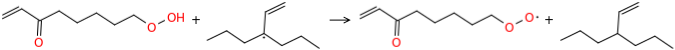

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.05407e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.6 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


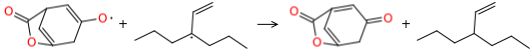

Arrhenius(A=(1.08e+14,'cm^3/(mol*s)'), n=-0.75, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [C_ter_rad;Csec_Rrad] for rate rule [C_rad/Cs2;C/H/DeDe_Csrad]
Euclidian distance = 2.8284271247461903
family: Disproportionation""")
Arrhenius(A=(1.93265e+13,'cm^3/(mol*s)'), n=-0.75, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [C_ter_rad;Csec_Rrad] for rate rule [C_rad/Cs2;C/H/DeDe_Csrad]
Euclidian distance = 2.8284271247461903
family: Disproportionation
Reduced by a factor of 5.6 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


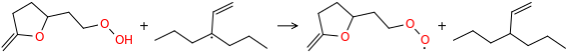

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.14254e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.5 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


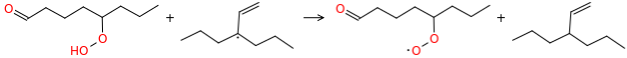

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.30318e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.4 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


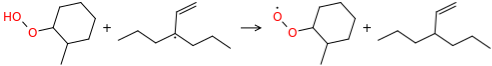

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.37837e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.4 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


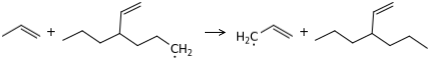

Arrhenius(A=(0.000296135,'cm^3/(mol*s)'), n=4.545, Ea=(4.565,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [C/H3/Cd\H_Cd\H2;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 3.0
family: H_Abstraction""")
Arrhenius(A=(5.48431e-05,'cm^3/(mol*s)'), n=4.545, Ea=(4.565,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [C/H3/Cd\H_Cd\H2;C_rad/H2/Cs]
Euclidian distance = 0
Multiplied by reaction path degeneracy 3.0
family: H_Abstraction
Reduced by a factor of 5.4 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


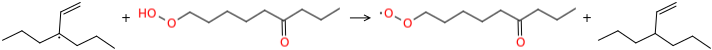

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.55075e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.3 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


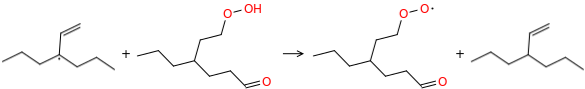

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.56599e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.3 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


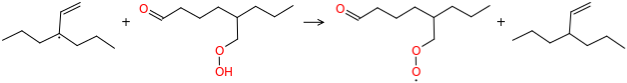

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.56599e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.3 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


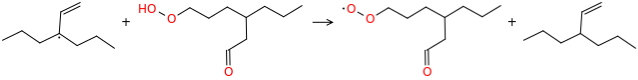

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.56599e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.3 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


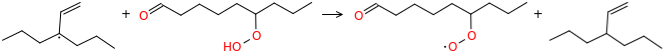

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.57076e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.3 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


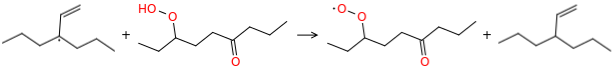

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.65352e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.2 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


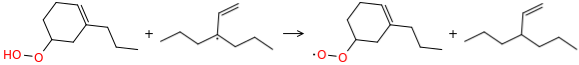

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.68643e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.2 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


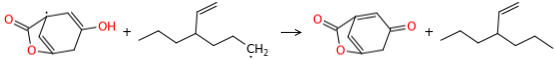

Arrhenius(A=(2.41e+12,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""From training reaction 58 used for C_rad/H2/Cs;O_Csrad
Exact match found for rate rule [C_rad/H2/Cs;O_Csrad]
Euclidian distance = 0
family: Disproportionation""")
Arrhenius(A=(4.62643e+11,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""From training reaction 58 used for C_rad/H2/Cs;O_Csrad
Exact match found for rate rule [C_rad/H2/Cs;O_Csrad]
Euclidian distance = 0
family: Disproportionation
Reduced by a factor of 5.2 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


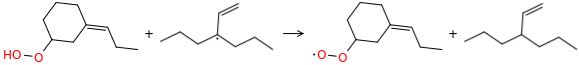

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.74926e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.2 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


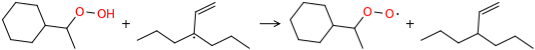

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.76726e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.2 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


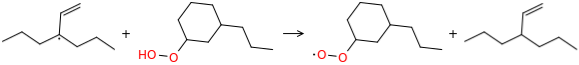

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.81348e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.2 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


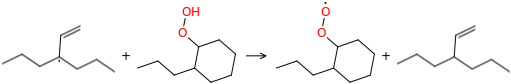

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.81348e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.2 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


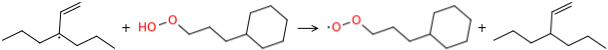

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.94977e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_pri;C_ter_rad] for rate rule [ROOH_pri;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


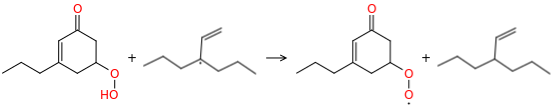

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.97549e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


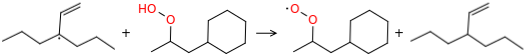

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.99815e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


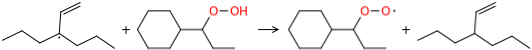

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(9.99815e-15,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


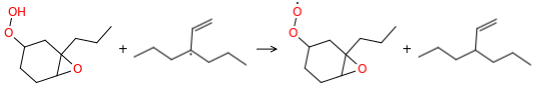

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(1.00136e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5.1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


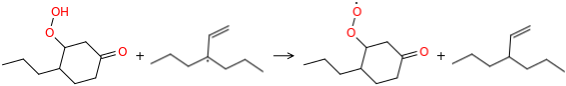

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(1.00897e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


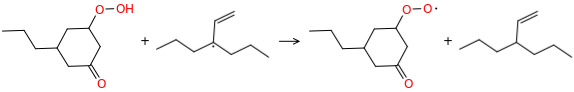

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(1.00897e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


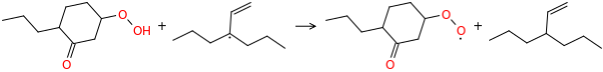

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction""")
Arrhenius(A=(1.00922e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [ROOH_sec;C_ter_rad] for rate rule [ROOH_sec;C_rad/CdCs2]
Euclidian distance = 3.0
family: H_Abstraction
Reduced by a factor of 5 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


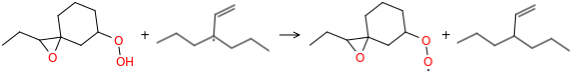

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.01439e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 5 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


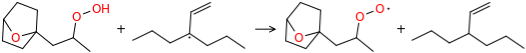

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.01935e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 5 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


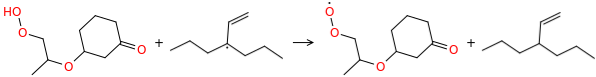

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.0404e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.9 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


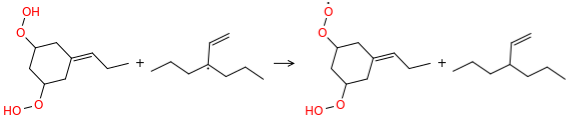

Arrhenius(A=(1.0132e-13,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.10819e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.8 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


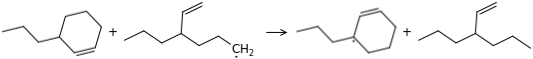

Arrhenius(A=(0.000552,'cm^3/(mol*s)'), n=4.34, Ea=(2.2,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(0.000114985,'cm^3/(mol*s)'), n=4.34, Ea=(2.2,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.8 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


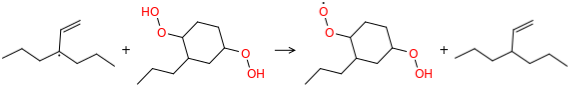

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.06326e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.8 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


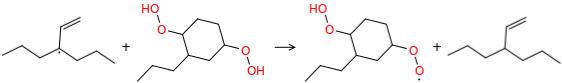

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.06326e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.8 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


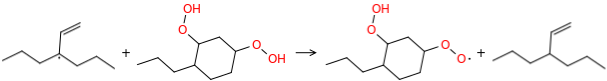

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.06326e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.8 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


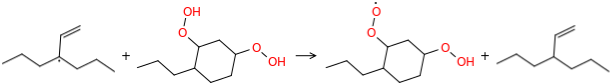

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.06326e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.8 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


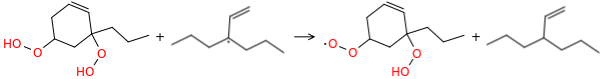

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.0677e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


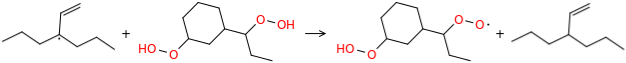

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.08161e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


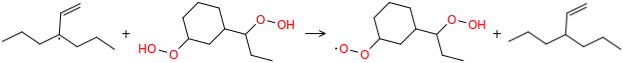

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.08161e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


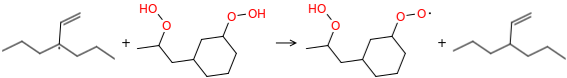

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.08161e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


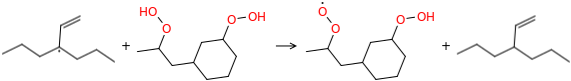

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.08161e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


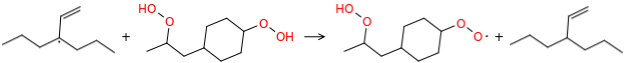

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.08161e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


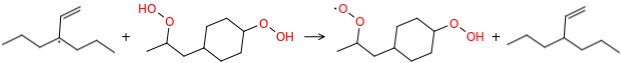

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.08161e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


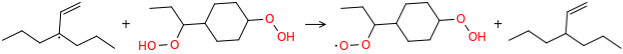

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.08161e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


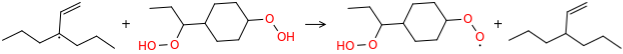

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.08161e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


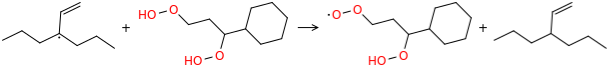

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.09951e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.6 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


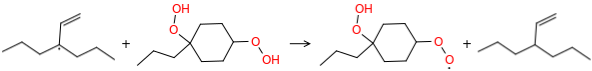

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.10033e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.6 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


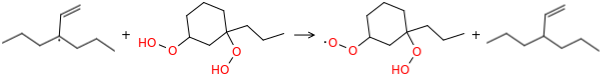

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.10033e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.6 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


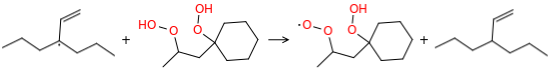

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.11909e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.5 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


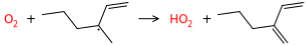

Arrhenius(A=(4.338e+13,'cm^3/(mol*s)'), n=0, Ea=(15.99,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(9.63809e+12,'cm^3/(mol*s)'), n=0, Ea=(15.99,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 4.5 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


ThirdBody(arrheniusLow=Arrhenius(A=(5.8e+12,'cm^3/(mol*s)'), n=0.5, Ea=(68.5,'kcal/mol'), T0=(1,'K')), efficiencies={})
ThirdBody(arrheniusLow=Arrhenius(A=(1.35846e+12,'cm^3/(mol*s)'), n=0.5, Ea=(68.5,'kcal/mol'), T0=(1,'K')), efficiencies={}, comment="""Reduced by a factor of 4.3 to avoid reverse rate violating the collision limit at 500 K, 40.0 bar""")


ThirdBody(arrheniusLow=Arrhenius(A=(6e+14,'cm^6/(mol^2*s)'), n=1.25, Ea=(-0.27,'kcal/mol'), T0=(1,'K')), efficiencies={})
ThirdBody(arrheniusLow=Arrhenius(A=(1.53175e+14,'cm^6/(mol^2*s)'), n=1.25, Ea=(-0.27,'kcal/mol'), T0=(1,'K')), efficiencies={}, comment="""Reduced by a factor of 3.9 to avoid forward rate violating the collision limit at 500 K, 40.0 bar""")


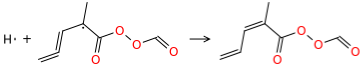

Arrhenius(A=(9.28426e+23,'cm^3/(mol*s)'), n=-3.05, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.52419e+23,'cm^3/(mol*s)'), n=-3.05, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 3.7 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


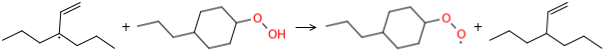

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.51672e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 3.3 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


Arrhenius(A=(1.086e+15,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.29236e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 3.3 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(1.086e+15,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.33932e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 3.3 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


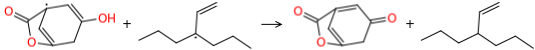

Arrhenius(A=(3.47e+14,'cm^3/(mol*s)'), n=-0.75, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.1151e+14,'cm^3/(mol*s)'), n=-0.75, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 3.1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


Arrhenius(A=(1.086e+15,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.52618e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 3.1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


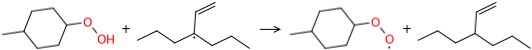

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.83741e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.8 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


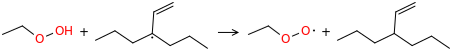

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(1.87936e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


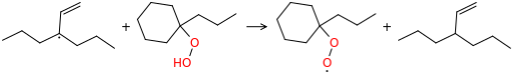

Arrhenius(A=(6.7709e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.92544e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.3 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


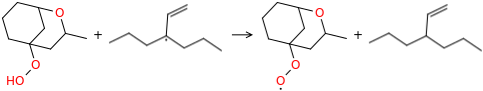

Arrhenius(A=(6.7709e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.97542e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.3 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


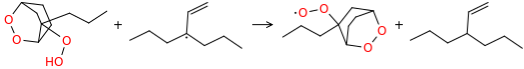

Arrhenius(A=(6.7709e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.9765e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.3 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


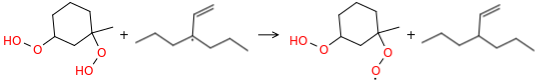

Arrhenius(A=(6.7709e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.99782e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.3 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


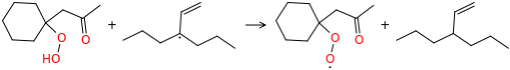

Arrhenius(A=(6.7709e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.99853e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.3 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


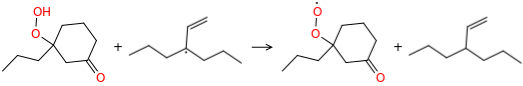

Arrhenius(A=(6.7709e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.01243e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.2 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


Arrhenius(A=(4.6e+19,'cm^3/(mol*s)'), n=-1.41, Ea=(28.95,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.05417e+19,'cm^3/(mol*s)'), n=-1.41, Ea=(28.95,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.2 to avoid reverse rate violating the collision limit at 500 K, 1.0 bar""")


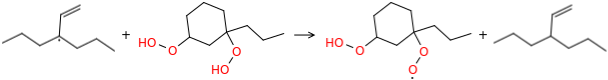

Arrhenius(A=(6.7709e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.17415e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


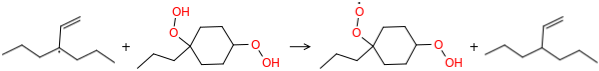

Arrhenius(A=(6.7709e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.17415e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


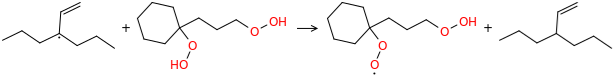

Arrhenius(A=(6.7709e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.21656e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


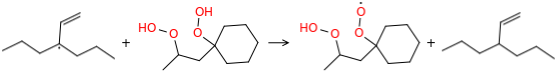

Arrhenius(A=(6.7709e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.22827e-09,'cm^3/(mol*s)'), n=5.714, Ea=(-2.652,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.63592e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2.1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


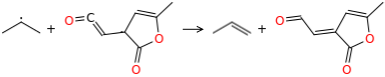

Arrhenius(A=(1.086e+15,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(5.33105e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(4e+07,'cm^3/(mol*s)'), n=1.65, Ea=(0.327,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.03949e+07,'cm^3/(mol*s)'), n=1.65, Ea=(0.327,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 2 to avoid reverse rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.84928e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.9 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.88058e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.9 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.89096e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.9 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.94784e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.8 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.99928e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.8 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.07741e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.8 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.10825e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.7 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.12619e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.7 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.13835e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.7 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


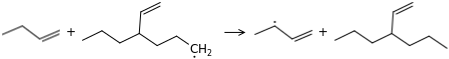

Arrhenius(A=(0.001806,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(0.00104421,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.7 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.18349e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.7 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.18789e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.7 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.21293e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.7 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.24561e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.7 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.31457e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.6 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


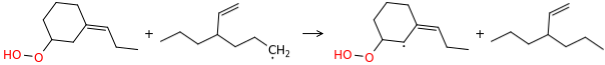

Arrhenius(A=(0.001806,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(0.00110305,'cm^3/(mol*s)'), n=4.34, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.6 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.36932e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.6 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.44555e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.6 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


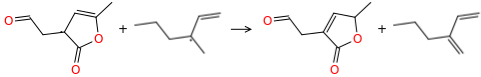

Arrhenius(A=(8.58e+15,'cm^3/(mol*s)'), n=-1.1, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(5.63758e+15,'cm^3/(mol*s)'), n=-1.1, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.5 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.61087e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.5 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


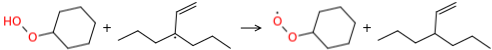

Arrhenius(A=(5.066e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.42576e-14,'cm^3/(mol*s)'), n=7.18, Ea=(-5.27,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.5 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


Arrhenius(A=(2.9e+26,'cm^3/(mol*s)'), n=-2.18, Ea=(36.77,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(2.06747e+26,'cm^3/(mol*s)'), n=-2.18, Ea=(36.77,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.4 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


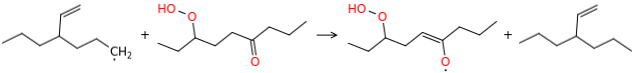

Arrhenius(A=(0.000312,'cm^3/(mol*s)'), n=4.31, Ea=(3.39,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(0.000222915,'cm^3/(mol*s)'), n=4.31, Ea=(3.39,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.4 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


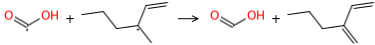

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.01167e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.4 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.02011e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.4 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


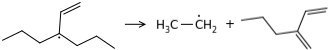

Troe(arrheniusHigh=Arrhenius(A=(3.39e+11,'s^-1'), n=0.66, Ea=(32.263,'kcal/mol'), T0=(1,'K')), arrheniusLow=Arrhenius(A=(4e-42,'cm^3/(mol*s)'), n=18.045, Ea=(-0.603,'kcal/mol'), T0=(1,'K')), alpha=-18.5, T3=(246,'K'), T1=(28,'K'), T2=(50000,'K'), efficiencies={Molecule(smiles="C"): 2.0, Molecule(smiles="O=C=O"): 2.0, Molecule(smiles="CC"): 3.0, Molecule(smiles="O"): 6.0, Molecule(smiles="[H][H]"): 2.0, Molecule(smiles="[C-]#[O+]"): 1.5, Molecule(smiles="[Ar]"): 0.7})
Troe(arrheniusHigh=Arrhenius(A=(2.60266e+11,'s^-1'), n=0.66, Ea=(32.263,'kcal/mol'), T0=(1,'K')), arrheniusLow=Arrhenius(A=(3.07098e-42,'cm^3/(mol*s)'), n=18.045, Ea=(-0.603,'kcal/mol'), T0=(1,'K')), alpha=-18.5, T3=(246,'K'), T1=(28,'K'), T2=(50000,'K'), efficiencies={Molecule(smiles="C"): 2.0, Molecule(smiles="O=C=O"): 2.0, Molecule(smiles="CC"): 3.0, Molecule(smiles="O"): 6.0, Molecule(smiles="[H][H]"): 2.0, Molecule(smiles="[C-]#[O+]"): 1.5, Molecule(smiles="[Ar]"): 0.7}, comment="""Reduced by a factor of 1.3 to avoid 

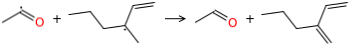

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.25538e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.3 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


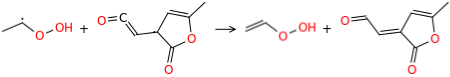

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.37694e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.2 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


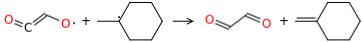

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.48016e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.2 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


Chebyshev(coeffs=[[-33.14,1.228,-0.3015,-0.02704],[34.36,0.1901,0.05871,-0.01129],[-0.3325,0.1346,0.03683,-0.008006],[-0.1738,0.06357,0.01972,-0.001457],[-0.08534,0.02635,0.009974,0.0007647],[-0.03543,0.005108,0.004302,0.001766]], kunits='s^-1', Tmin=(300,'K'), Tmax=(2000,'K'), Pmin=(0.01,'atm'), Pmax=(98.692,'atm'))
Chebyshev(coeffs=[[-33.2164,1.228,-0.3015,-0.02704],[34.36,0.1901,0.05871,-0.01129],[-0.3325,0.1346,0.03683,-0.008006],[-0.1738,0.06357,0.01972,-0.001457],[-0.08534,0.02635,0.009974,0.0007647],[-0.03543,0.005108,0.004302,0.001766]], kunits='s^-1', Tmin=(300,'K'), Tmax=(2000,'K'), Pmin=(0.01,'atm'), Pmax=(98.692,'atm'), comment="""Reduced by a factor of 1.2 to avoid reverse rate violating the collision limit at 500 K, 40.0 bar""")


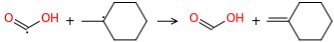

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.61276e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.2 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


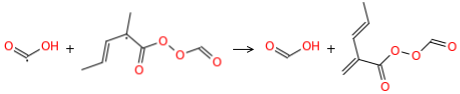

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.65156e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.2 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


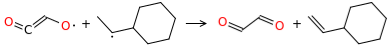

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.66999e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.2 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


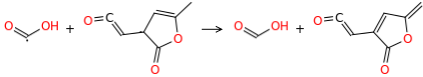

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.77242e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


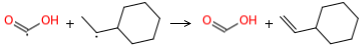

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.83697e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


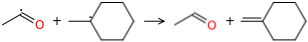

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.86946e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


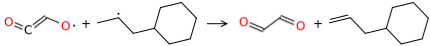

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.87892e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


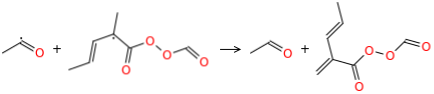

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(4.91085e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


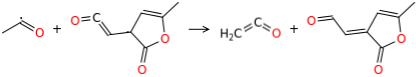

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(5.0341e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


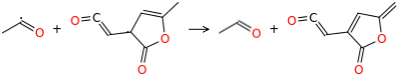

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(5.0341e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


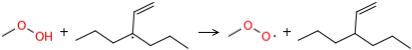

Arrhenius(A=(8.17661e-06,'cm^3/(mol*s)'), n=4.92, Ea=(8.992,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(7.62594e-06,'cm^3/(mol*s)'), n=4.92, Ea=(8.992,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


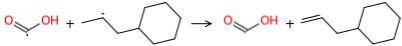

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(5.07995e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


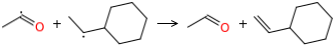

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(5.09781e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1.1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


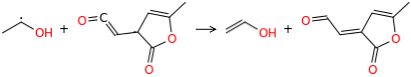

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(5.21967e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


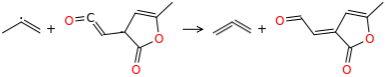

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(5.27954e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


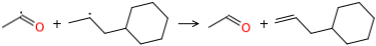

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(5.34538e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


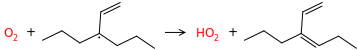

Arrhenius(A=(3.666e+13,'cm^3/(mol*s)'), n=0, Ea=(14.85,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(3.61998e+13,'cm^3/(mol*s)'), n=0, Ea=(14.85,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


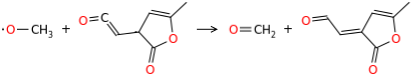

Arrhenius(A=(5.43e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(5.37767e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1 to avoid forward rate violating the collision limit at 500 K, 1.0 bar""")


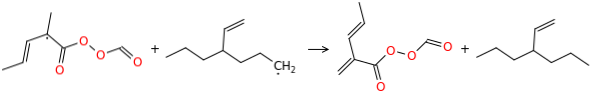

Arrhenius(A=(6.9e+13,'cm^3/(mol*s)'), n=-0.35, Ea=(0,'kcal/mol'), T0=(1,'K'))
Arrhenius(A=(6.84459e+13,'cm^3/(mol*s)'), n=-0.35, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Reduced by a factor of 1 to avoid reverse rate violating the collision limit at 1500 K, 1.0 bar""")


In [25]:

for r, details in worst_offenders.items():
    direction, ratio, conditions = details
    display(r)
    print(r.kinetics)
    r.kinetics.change_rate(1 / ratio)
    r.kinetics.comment = (r.kinetics.comment+f"\nReduced by a factor of {ratio :.2g} to avoid {direction} rate violating the collision limit at {conditions}").strip()
    print(r.kinetics)

        
    

In [26]:
from rmgpy.data.reference import *
from rmgpy.data.base import Entry
from rmgpy import settings
from rmgpy.data.kinetics import KineticsLibrary, LibraryReaction

library_name = 'violator_fixes_500-1500K'
library = KineticsLibrary()
library.name = library_name
library.label =library_name
library.short_desc = "Rates reduced to match the collision limit"
library.long_desc = """
This library is the result of detecting collision limit violators,
scaling them down so they no longer violate the collision limit
"""

for violator in violators:
    reaction = violator[0]
    print(reaction)
    
    long_desc = (reaction.comment + '\n' + reaction.kinetics.comment).strip()
    
    entry = Entry(index=reaction.index,
                 label=str(reaction),
                 item=reaction,
                 parent=None,
                 children=None,
                 data=reaction.kinetics,
                 reference=None,
                 short_desc=long_desc,
                 long_desc=long_desc,
                 rank=None)
    library.entries[reaction.index] = entry
    

CH2O(6) + S(103) => HCO(68) + CH2OH(72) + CH2OOH(82)
C6H5(135) => H(12) + C2H2(80) + C4H2(117)
CH3_1(24) <=> H(12) + CH2(69)
HO2_1(22) + S(103) => O2(13) + CH2OH(72) + CH2OOH(82)
CH3_1(24) <=> H2(9) + CH(2)
CH3_1(24) <=> H(12) + CH2(69)
CH3_1(24) <=> H2(9) + CH(2)
C2H2(80) <=> H(12) + C2H(3)
S(382) + C9H17(300) <=> S(9816) + C9H18(14)
CH2(69) <=> H(12) + CH(2)
S(28969) + C9H17(300) <=> S(28962) + C9H18(14)
S(37526) + C9H17(300) <=> S(37521) + C9H18(14)
S(44703) + C9H17(300) <=> S(44700) + C9H18(14)
S(10510) + C9H17(300) <=> S(2729) + C9H18(14)
C9H17(300) + S(46389) <=> S(46386) + C9H18(14)
C9H17(300) + S(4131) <=> S(4128) + C9H18(14)
C9H17(300) + S(26883) <=> S(26880) + C9H18(14)
C9H17(300) + S(28231) <=> S(28198) + C9H18(14)
C9H17(300) + S(45578) <=> S(45575) + C9H18(14)
C9H17(300) + S(19484) <=> S(19473) + C9H18(14)
S(3416) + C9H17(300) <=> S(8199) + C9H18(14)
S(3415) + C9H17(300) <=> S(9447) + C9H18(14)
S(3271) + C9H17(300) <=> S(2734) + C9H18(14)
C9H17(300) + S(3113) <=> S(2727) + 

In [42]:
# We need to put the speices labels onto the species
# so they are saved in the dictionary
for label, species in species_dict.items():
    print(label, species.label)
    species.label = label
    print(label, species.label)

N2 N2
N2 N2
Ar Ar
Ar Ar
Ne Ne
Ne Ne
n-pch(1) n-pch
n-pch(1) n-pch(1)
CH(2) CH
CH(2) CH(2)
C2H(3) C2H
C2H(3) C2H(3)
CO(4) CO
CO(4) CO(4)
CO2(5) CO2
CO2(5) CO2(5)
CH2O(6) CH2O
CH2O(6) CH2O(6)
C2H4(7) C2H4
C2H4(7) C2H4(7)
C3H6(8) C3H6
C3H6(8) C3H6(8)
H2(9) H2
H2(9) H2(9)
iC4H8(10) iC4H8
iC4H8(10) iC4H8(10)
OH(11) OH
OH(11) OH(11)
H(12) H
H(12) H(12)
O2(13) O2
O2(13) O2(13)
C9H18(14) C9H18
C9H18(14) C9H18(14)
C9H18(15) C9H18
C9H18(15) C9H18(15)
C9H18(16) C9H18
C9H18(16) C9H18(16)
C9H18(17) C9H18
C9H18(17) C9H18(17)
C9H18(18) C9H18
C9H18(18) C9H18(18)
C9H18(19) C9H18
C9H18(19) C9H18(19)
O_1(20) O_1
O_1(20) O_1(20)
ROH_1(21) ROH_1
ROH_1(21) ROH_1(21)
HO2_1(22) HO2_1
HO2_1(22) HO2_1(22)
H2O2(23) H2O2
H2O2(23) H2O2(23)
CH3_1(24) CH3_1
CH3_1(24) CH3_1(24)
RCH4_1(25) RCH4_1
RCH4_1(25) RCH4_1(25)
C9H16(26) C9H16
C9H16(26) C9H16(26)
C9H16(27) C9H16
C9H16(27) C9H16(27)
C9H16(28) C9H16
C9H16(28) C9H16(28)
C9H16(29) C9H16
C9H16(29) C9H16(29)
C8H14(30) C8H14
C8H14(30) C8H14(30)
C9H16(31) C9H16
C9H16(3

In [43]:
library.entries[583].item.reactants

[Species(index=6, label="CH2O(6)", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[4.79372,-0.00990833,3.7322e-05,-3.79285e-08,1.31773e-11,-14379.2,0.602798], Tmin=(200,'K'), Tmax=(1000,'K')), NASAPolynomial(coeffs=[3.16953,0.00619321,-2.25056e-06,3.65976e-10,-2.20149e-14,-14548.7,6.04208], Tmin=(1000,'K'), Tmax=(6000,'K'))], Tmin=(200,'K'), Tmax=(6000,'K'), comment="""Thermo library: Klippenstein_Glarborg2016"""), molecule=[Molecule(smiles="C=O")], transport_data=TransportData(shapeIndex=2, epsilon=(4140.61,'J/mol'), sigma=(3.59,'angstrom'), dipoleMoment=(0,'De'), polarizability=(0,'angstrom^3'), rotrelaxcollnum=2.0, comment="""NOx2018"""), molecular_weight=(30.026,'amu')),
 Species(index=103, label="S(103)", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[0.556418,0.0412519,-3.10647e-05,1.2293e-08,-1.99691e-12,-22047.4,24.9983], Tmin=(298,'K'), Tmax=(800,'K')), NASAPolynomial(coeffs=[0.556418,0.0412519,-3.10647e-05,1.2293e-08,-1.99691e-12,-22047.4,24.9983], Tmin=(800,'K'), Tmax=(2500

In [44]:
library.save(os.path.join(settings['database.directory'],f"{library.name}/reactions.py"))
library.save(os.path.join(settings['database.directory'],f"{library.name}/dictionary.txt"))
print(os.path.join(settings['database.directory'],f"{library.name}/dictionary.txt"))

/scratch/ajulu.c/Code/RMG-database/input/violator_fixes_500-1500K/dictionary.txt


In [45]:
%cat /scratch/ajulu.c/Code/RMG-database/input/violator_fixes_500-1500K/dictionary.txt

CH2O(6)
1 O u0 p2 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,S} {4,S}
3 H u0 p0 c0 {2,S}
4 H u0 p0 c0 {2,S}

S(103)
multiplicity 2
1  O u0 p2 c0 {3,S} {4,S}
2  O u0 p2 c0 {5,S} {10,S}
3  O u1 p2 c0 {1,S}
4  C u0 p0 c0 {1,S} {5,S} {6,S} {7,S}
5  C u0 p0 c0 {2,S} {4,S} {8,S} {9,S}
6  H u0 p0 c0 {4,S}
7  H u0 p0 c0 {4,S}
8  H u0 p0 c0 {5,S}
9  H u0 p0 c0 {5,S}
10 H u0 p0 c0 {2,S}

HCO(68)
multiplicity 2
1 O u0 p2 c0 {2,D}
2 C u1 p0 c0 {1,D} {3,S}
3 H u0 p0 c0 {2,S}

CH2OH(72)
multiplicity 2
1 O u0 p2 c0 {2,S} {5,S}
2 C u1 p0 c0 {1,S} {3,S} {4,S}
3 H u0 p0 c0 {2,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {1,S}

CH2OOH(82)
multiplicity 2
1 O u0 p2 c0 {2,S} {3,S}
2 O u0 p2 c0 {1,S} {6,S}
3 C u1 p0 c0 {1,S} {4,S} {5,S}
4 H u0 p0 c0 {3,S}
5 H u0 p0 c0 {3,S}
6 H u0 p0 c0 {2,S}

C6H5(135)
multiplicity 2
1  C u0 p0 c0 {2,B} {3,B} {8,S}
2  C u0 p0 c0 {1,B} {4,B} {7,S}
3  C u0 p0 c0 {1,B} {5,B} {9,S}
4  C u0 p0 c0 {2,B} {6,B} {10,S}
5  C u0 p0 c0 {3,B} {6,B} {11,S}
6  C u1 p0 c0 {4,B} {5,B}
7  H u0 p0 c0 {2,S}
8  H u0

In [52]:
violator_species = library.get_species('../no_lowT/violator_fixes_500-1500K/dictionary.txt')

violator_species.keys()
species_dict.keys()

dict_keys(['N2', 'Ar', 'Ne', 'n-pch(1)', 'CH(2)', 'C2H(3)', 'CO(4)', 'CO2(5)', 'CH2O(6)', 'C2H4(7)', 'C3H6(8)', 'H2(9)', 'iC4H8(10)', 'OH(11)', 'H(12)', 'O2(13)', 'C9H18(14)', 'C9H18(15)', 'C9H18(16)', 'C9H18(17)', 'C9H18(18)', 'C9H18(19)', 'O_1(20)', 'ROH_1(21)', 'HO2_1(22)', 'H2O2(23)', 'CH3_1(24)', 'RCH4_1(25)', 'C9H16(26)', 'C9H16(27)', 'C9H16(28)', 'C9H16(29)', 'C8H14(30)', 'C9H16(31)', 'C7H12(32)', 'C6H10(33)', 'C9H16(34)', 'C6H11(35)', 'C7H13(36)', 'C9H17(37)', 'C9H17(38)', 'C9H17(39)', 'C9H17(40)', 'C9H17(41)', 'C9H17(42)', 'C9H17(43)', 'C8H15(44)', 'C7H13(45)', 'QOOH_1(46)', 'QOOH_2(47)', 'QOOH_3(48)', 'QOOH_4(49)', 'QOOH_5(50)', 'QOOH_6(51)', 'QOOH_7(52)', 'QOOH_8(53)', 'QOOH_9(54)', 'C7H13(55)', 'C7H13(56)', 'C7H13(57)', 'C3H7(58)', 'C3H7(59)', 'C8H15(60)', 'C8H15(61)', 'C8H15(62)', 'C8H15(63)', 'C8H15(64)', 'C8H15(65)', 'He(66)', 'HOCO(67)', 'HCO(68)', 'CH2(69)', 'CH3OH(70)', 'CH2(S)(71)', 'CH2OH(72)', 'CH3O(73)', 'HCOH(74)', 'CH3OO(75)', 'CH2CO(76)', 'C2H5(77)', 'C2H3(78)'

In [68]:
import re 

def sequenece_matcher(species_dict, violator_species):

    for key in species_dict.keys():
        keyparts = key.split("(")
             
        if keyparts[0] not in violator_species:
            continue
            
        value = violator_species[keyparts[0]]
        
        del violator_species[keyparts[0]]
        
        violator_species[key] = value
        
sequenece_matcher(species_dict, violator_species) 

print(violator_species.keys())

odict_keys(['CH(2)', 'C(79)', 'S(103)', 'C2H(3)', 'CO(4)', 'CH2O(6)', 'C2H4(7)', 'C3H6(8)', 'H2(9)', 'OH(11)', 'O2(13)', 'C9H18(14)', 'O_1(20)', 'HO2_1(22)', 'H2O2(23)', 'CH3_1(24)', 'C9H16(26)', 'C8H14(30)', 'C7H12(32)', 'C6H10(33)', 'C6H11(35)', 'C7H13(36)', 'C9H17(37)', 'C8H15(44)', 'QOOH_5(50)', 'C3H7(58)', 'HOCO(67)', 'HCO(68)', 'CH2(69)', 'CH2OH(72)', 'CH3O(73)', 'CH3OO(75)', 'CH2CO(76)', 'C2H5(77)', 'C2H2(80)', 'CH3OOH(81)', 'CH2OOH(82)', 'CH3CHO(84)', 'C2H5O(85)', 'C2H5O2(86)', 'C2H4O(89)', 'OCHCHO(95)', 'CHCHOH(98)', 'C2O(100)', 'CH3CO(104)', 'HOCHO(106)', 'OCHCO(108)', 'C4H2(117)', 'aC3H4(121)', 'C3H5(122)', 'aC3H5(124)', 'C3H4O(127)', 'nC4H5(128)', 'C4H7(130)', 'C4H81(132)', 'C6H5(135)', 'lC5H7(141)'])


In [58]:
sequenece_matcher(species_dict,violator_species)

N2


TypeError: an integer is required (got type str)